# Analyses codes for Han et al., 2022

This Jupyter Notebook was used to analyse and create figures for _SARS-CoV-2 diagnostic testing rates determine the sensitivity of genomic surveillance programs_ (Han et al. 2022).  

## Import libraries 

In [1]:
import re
import os
import gzip
import json
import itertools
import numpy as np
import pandas as pd
np.seterr(all='raise')
import geopandas
import scipy.stats 
import scipy.sparse as sparse
from scipy.optimize import curve_fit
import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

if not os.path.isdir('gs_manuscript'): 
    os.mkdir('gs_manuscript')

## Figure 1

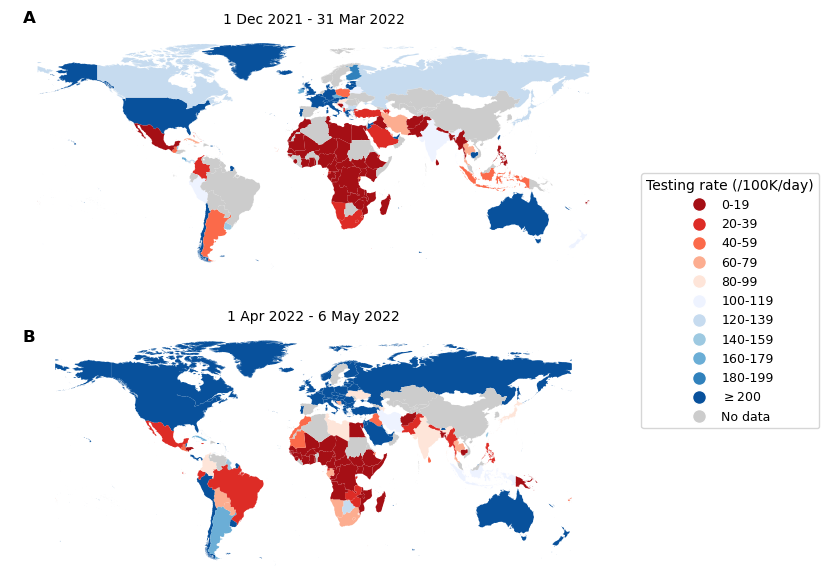

In [3]:
def generate_data(ax_i): 
    world = geopandas.read_file('./data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
    world = world[(world.SOVEREIGNT!="Antarctica")]

    find_all_data = pd.read_csv('./data/FIND_data_all.txt')
    find_all_data = find_all_data[find_all_data['set']=='country']

    find_all_data.loc[find_all_data[find_all_data['name']=='United States'].index, 'name'] = 'United States of America'
    find_all_data.loc[find_all_data[find_all_data['name']=='Timor-Leste'].index, 'name'] = 'East Timor'
    find_all_data.loc[find_all_data[find_all_data['name']=='St. Kitts & Nevis'].index, 'name'] = 'Saint Kitts and Nevis'
    find_all_data.loc[find_all_data[find_all_data['name']=='St. Lucia'].index, 'name'] = 'Saint Lucia'
    find_all_data.loc[find_all_data[find_all_data['name']=='Cape Verde'].index, 'name'] = 'Cabo Verde'
    find_all_data.loc[find_all_data[find_all_data['name']=='Trinidad & Tobago'].index, 'name'] = 'Trinidad and Tobago'
    find_all_data.loc[find_all_data[find_all_data['name']=='Sao Tome and Principe'].index, 'name'] = 'São Tomé and Principe'
    find_all_data.loc[find_all_data[find_all_data['name']=='Bosnia & Herzegovina'].index, 'name'] = 'Bosnia and Herzegovina'
    find_all_data.loc[find_all_data[find_all_data['name']=='Serbia'].index, 'name'] = 'Republic of Serbia'
    find_all_data.loc[find_all_data[find_all_data['name']=='Antigua & Barbuda'].index, 'name'] = 'Antigua and Barbuda'
    find_all_data.loc[find_all_data[find_all_data['name']=='Eswatini'].index, 'name'] = 'eSwatini'
    find_all_data.loc[find_all_data[find_all_data['name']=='Bahamas'].index, 'name'] = 'The Bahamas'
    find_all_data.loc[find_all_data[find_all_data['name']=='Myanmar (Burma)'].index, 'name'] = 'Myanmar'
    find_all_data.loc[find_all_data[find_all_data['name']=='St. Vincent & Grenadines'].index, 'name'] = 'Saint Vincent and the Grenadines'
    find_all_data.loc[find_all_data[find_all_data['name']=='Tanzania'].index, 'name'] = 'United Republic of Tanzania'
    find_all_data['date'] = pd.to_datetime(find_all_data['time'])

    common_countries = list(set(world['SOVEREIGNT'])&set(find_all_data['name']))

    daily_test = {}
    pop_100k = {}
    for country in common_countries: 
        country_fdf = find_all_data[(find_all_data['name']==(country))]
        country_fdf = country_fdf[~pd.isna(country_fdf['all_new_tests'])]
        
        if ax_i > 0: 
            mask = (country_fdf['date'] >= pd.to_datetime('2021-12-01'))&(country_fdf['date'] < pd.to_datetime('2022-04-01'))
        else: 
            mask = country_fdf['date'] >= pd.to_datetime('2022-04-01')
            
        if len(country_fdf[mask]) > 0: 
            country_fdf = country_fdf[mask]
        else: 
            continue 
            if ax_i == 0: 
                if len(country_fdf) == 0: 
                    continue 
            else: 
                continue 
        
        daily_test[country] = country_fdf['all_new_tests'].mean()
        pop_100k[country] = country_fdf['pop_100k'].iloc[0]
        
    world = world[world['SOVEREIGNT'].isin(common_countries)]
    world['daily_test'] = world['SOVEREIGNT'].map(daily_test)
    world['pop_100k'] = world['SOVEREIGNT'].map(pop_100k)
    world['daily_test_per_100k'] = world['daily_test']/world['pop_100k']

    world.loc[world[world['daily_test_per_100k']>200].index, 'daily_test_per_100k'] = 201
    world['test_rel_100'] = world['daily_test_per_100k']/100
    
    b_list = list(np.linspace(0, 200, 11)) + [201]

    for b, _bin in enumerate (b_list): 
        if b == 0: 
            continue 
        if _bin == 201: 
            world.loc[world[(world['daily_test_per_100k']==_bin)].index, 'c_index'] = b-1
        else:  
            world.loc[world[(world['daily_test_per_100k']>=b_list[b-1])&(world['daily_test_per_100k']<_bin)].index, 'c_index'] = b-1

    return world, b_list 
            
with plt.style.context("default"):
    fig = plt.figure(figsize=(8.3, 11.8 * 0.6))
    gs = GridSpec(nrows=2, ncols=1)
    
    ax = fig.add_subplot(gs[0])
    world, b_list = generate_data(0)
    color_list = ['#fee5d9','#fcae91','#fb6a4a','#de2d26','#a50f15'][::-1] + ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
    cmap = LinearSegmentedColormap.from_list('mycmap', [(i/10, color_list[i]) for i in np.arange(11)])
    p = world.plot(ax=ax, column='c_index', cmap=cmap, scheme='User_Defined', 
                   missing_kwds= dict(color = "#cccccc",),
                   classification_kwds=dict(bins=range(11)), legend=True,) #cax=cax)
    ax.get_legend().remove()   
    ax.axis('off')
    ax.set_title('1 Dec 2021 - 31 Mar 2022', fontsize=10)
    
    ### 
    
    ax = fig.add_subplot(gs[1])
    world, b_list = generate_data(1)
    color_list = ['#fee5d9','#fcae91','#fb6a4a','#de2d26','#a50f15'][::-1] + ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
    cmap = LinearSegmentedColormap.from_list('mycmap', [(i/10, color_list[i]) for i in np.arange(11)])
    p = world.plot(ax=ax, column='c_index', cmap=cmap, scheme='User_Defined',
                   missing_kwds= dict(color = "#cccccc",),                   
                   classification_kwds=dict(bins=range(11)), legend=True,) #cax=cax)    
    ax.axis('off')
    cmap = []
    for _ in ax.legend_.__dict__['legendHandles']: 
        cmap.append (_.__dict__['_markerfacecolor'])
    ax.get_legend().remove()
    ax.set_title('1 Apr 2022 - 6 May 2022', fontsize=10)    
    
    legend_elements = []
    for b, bins in enumerate(b_list[1:]): 
        if b == len(b_list[1:]) - 1: 
            blabel = r'$\geq$200'
        else: 
            blabel = '{:,}-{:,}'.format(int(b_list[b]), int(b_list[b+1])-1)
        
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=blabel,
                                      markerfacecolor=cmap[b], markersize=10),)
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label="No data",
                                      markerfacecolor="#cccccc", markersize=10),)
        
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.9, 0.5), fontsize=9, 
              title='Testing rate (/100K/day)')
    
    fig.text(s=r"$\bf{A}$", x=0.17, y=.9, fontsize=12, ha='center', va='center')
    fig.text(s=r"$\bf{B}$", x=0.17, y=.45, fontsize=12, ha='center', va='center')
    
    plt.savefig('./gs_manuscript/figure1.png', dpi=330, bbox_inches='tight')
    #plt.savefig('./gs_manuscript/figure1.pdf', bbox_inches='tight')    
    plt.show()

In [4]:
fdf = pd.read_csv('./data/FIND_country_info.txt')
fdf.loc[fdf[fdf['name']=='United States'].index, 'name'] = 'United States of America'
fdf.loc[fdf[fdf['name']=='Timor-Leste'].index, 'name'] = 'East Timor'
fdf.loc[fdf[fdf['name']=='St. Kitts & Nevis'].index, 'name'] = 'Saint Kitts and Nevis'
fdf.loc[fdf[fdf['name']=='St. Lucia'].index, 'name'] = 'Saint Lucia'
fdf.loc[fdf[fdf['name']=='Cape Verde'].index, 'name'] = 'Cabo Verde'
fdf.loc[fdf[fdf['name']=='Trinidad & Tobago'].index, 'name'] = 'Trinidad and Tobago'
fdf.loc[fdf[fdf['name']=='Sao Tome and Principe'].index, 'name'] = 'São Tomé and Principe'
fdf.loc[fdf[fdf['name']=='Bosnia & Herzegovina'].index, 'name'] = 'Bosnia and Herzegovina'
fdf.loc[fdf[fdf['name']=='Serbia'].index, 'name'] = 'Republic of Serbia'
fdf.loc[fdf[fdf['name']=='Antigua & Barbuda'].index, 'name'] = 'Antigua and Barbuda'
fdf.loc[fdf[fdf['name']=='Eswatini'].index, 'name'] = 'eSwatini'
fdf.loc[fdf[fdf['name']=='Bahamas'].index, 'name'] = 'The Bahamas'
fdf.loc[fdf[fdf['name']=='Myanmar (Burma)'].index, 'name'] = 'Myanmar'
fdf.loc[fdf[fdf['name']=='St. Vincent & Grenadines'].index, 'name'] = 'Saint Vincent and the Grenadines'
fdf.loc[fdf[fdf['name']=='Tanzania'].index, 'name'] = 'United Republic of Tanzania'
c_income_dict = fdf[['name', 'income']].set_index('name').to_dict()['income']

find_all_data = pd.read_csv('./data/FIND_data_all.txt')
find_all_data = find_all_data[find_all_data['set']=='country']

find_all_data.loc[find_all_data[find_all_data['name']=='United States'].index, 'name'] = 'United States of America'
find_all_data.loc[find_all_data[find_all_data['name']=='Timor-Leste'].index, 'name'] = 'East Timor'
find_all_data.loc[find_all_data[find_all_data['name']=='St. Kitts & Nevis'].index, 'name'] = 'Saint Kitts and Nevis'
find_all_data.loc[find_all_data[find_all_data['name']=='St. Lucia'].index, 'name'] = 'Saint Lucia'
find_all_data.loc[find_all_data[find_all_data['name']=='Cape Verde'].index, 'name'] = 'Cabo Verde'
find_all_data.loc[find_all_data[find_all_data['name']=='Trinidad & Tobago'].index, 'name'] = 'Trinidad and Tobago'
find_all_data.loc[find_all_data[find_all_data['name']=='Sao Tome and Principe'].index, 'name'] = 'São Tomé and Principe'
find_all_data.loc[find_all_data[find_all_data['name']=='Bosnia & Herzegovina'].index, 'name'] = 'Bosnia and Herzegovina'
find_all_data.loc[find_all_data[find_all_data['name']=='Serbia'].index, 'name'] = 'Republic of Serbia'
find_all_data.loc[find_all_data[find_all_data['name']=='Antigua & Barbuda'].index, 'name'] = 'Antigua and Barbuda'
find_all_data.loc[find_all_data[find_all_data['name']=='Eswatini'].index, 'name'] = 'eSwatini'
find_all_data.loc[find_all_data[find_all_data['name']=='Bahamas'].index, 'name'] = 'The Bahamas'
find_all_data.loc[find_all_data[find_all_data['name']=='Myanmar (Burma)'].index, 'name'] = 'Myanmar'
find_all_data.loc[find_all_data[find_all_data['name']=='St. Vincent & Grenadines'].index, 'name'] = 'Saint Vincent and the Grenadines'
find_all_data.loc[find_all_data[find_all_data['name']=='Tanzania'].index, 'name'] = 'United Republic of Tanzania'
find_all_data['date'] = pd.to_datetime(find_all_data['time'])

common_countries = list(set(world['SOVEREIGNT'])&set(find_all_data['name']))

In [5]:
df = []
for country in find_all_data['name'].unique():
    
    mask1 = find_all_data['name']==country
    mask2 = (find_all_data['date']>=pd.to_datetime("2021-12-01"))&(find_all_data['date']<=pd.to_datetime("2022-03-31"))
    a = find_all_data[mask1&mask2]['all_new_tests'].mean()/find_all_data[mask1&mask2]['pop_100k'].mean()

    mask2 = (find_all_data['date']>=pd.to_datetime("2022-04-01"))
    b = find_all_data[mask1&mask2]['all_new_tests'].mean()/find_all_data[mask1&mask2]['pop_100k'].mean()
    
    df.append({'country':country, 'before_omicron':a, 'after_omicron':b, 'income':c_income_dict[country]})
    
df = pd.DataFrame.from_dict(df).dropna()
df['i'] = df['income'].map({'Low':0, 'Lower middle':1, 'Upper middle':2, 'High':3})
df = df.sort_values(by=['i', 'country'])
df.to_csv('./data/mean_test_rate_income.csv', index=False)

## Inputs and parameters

In [6]:
seq_prop_arr = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]  
test_N_arr = [27, 100, 200, 400, 600, 800, 1000]
f_mutant_beta_arr = [1., 3.]

# three modalities - (0) centralised, (1) all tert, (2) 1 tert, (3) 10% tert, (4) 25% tert, (5) 50% tert, 
seq_mode_arr = np.arange(6) 
seq_mode_cols = ['#7f3b08','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b']

prop_hospitalised_samples_diagnosed = 0.3 # proportion of hospitalised samples that are diagnosed
prop_hcfs_tertiary = 0.2 # proportion of all HCFs that are tertiary facilities 

seq_success_prob = 0.8

var_cols = ['#404040','#ca0020',]
var_type_arr = ['alpha', 'omicron']
test_N_cmap = sns.color_palette('Spectral', len(test_N_arr))

## Read summary jsons of previously simulated epidemics 

In [7]:
summary_df = []
for virus, summary_folder in zip(var_type_arr, ['./PATAT_gs_ms_data/20220201_alpha_surv_summary', 
                                                './PATAT_gs_ms_data/20220201_surv_summary']):
    for fname in os.listdir(summary_folder): 
        # load and read json 
        with gzip.open("%s/%s"%(summary_folder, fname), "r") as f:
            data = f.read()
            row = json.loads(data.decode('utf-8'))
        # variant virus 
        row['virus'] = virus
        # get f_mutant_beta 
        f_mutant_beta = row['f_mutant_beta']
        summary_df.append(row)
        
summary_df = pd.DataFrame.from_dict(summary_df)
summary_df.head()

,init_mt_prop,init_immune_prop,f_mutant_beta,number_of_rdt_per_100k_per_day,nc_demand,fpath,set_id,run_id,weekdays_arr,sus_arr,...,mt_infectious_arr,diagnosed_var_arr,diagnosed_agents_arr,diagnosed_day_arr,diagnosed_hcf_arr,all_hcf_n,falpos_agents_arr,falpos_day_arr,falpos_hcf_arr,virus
0,0.0001,0.1,4.0,600,1,./20220210_alpha_surv_detect/alpha_surv_baseli...,34,3,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[885709, 880953, 875799, 871366, 866710, 86088...",...,"[0.0, 0.0, 5.0, 23.0, 50.0, 75.0, 104.0, 139.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[27, 30, 76, 208, 211, 241, 255, 261, 262, 301...","[10, 2, 7, 12, 7, 1, 24, 10, 7, 31, 24, 45, 8,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[158156, 176043, 192297, 402984, 440207, 53276...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[22, 25, 27, 57, 63, 76, 77, 77, 81, 108, 130,...",alpha
1,0.0001,0.1,1.0,400,1,./20220210_alpha_surv_detect/alpha_surv_baseli...,21,3,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[885746, 881079, 875870, 871219, 866508, 86067...",...,"[0.0, 0.0, 2.0, 28.0, 54.0, 82.0, 95.0, 101.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[30, 98, 103, 139, 176, 191, 198, 238, 313, 38...","[2, 17, 45, 52, 31, 31, 52, 52, 11, 45, 45, 53...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[32501, 172675, 187509, 201746, 415663, 462585...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[4, 24, 26, 28, 59, 66, 79, 81, 82, 85, 111, 1...",alpha
2,0.0001,0.1,1.8,600,1,./20220210_alpha_surv_detect/alpha_surv_baseli...,31,1,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[889011, 887955, 886579, 884413, 880422, 87510...",...,"[0.0, 1.0, 5.0, 34.0, 60.0, 77.0, 100.0, 123.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10, 78, 84, 86, 136, 159, 190, 205, 241, 255,...","[31, 11, 17, 17, 59, 11, 31, 17, 31, 6, 11, 6,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[19889, 44131, 134479, 136173, 276228, 287705,...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 6, 19, 19, 39, 41, 82, 0, 0, 6, 9, 11, 12,...",alpha
3,0.0001,0.1,1.8,400,1,./20220210_alpha_surv_detect/alpha_surv_baseli...,24,1,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[889064, 888017, 886646, 884491, 880715, 87547...",...,"[0.0, 1.0, 6.0, 36.0, 62.0, 83.0, 99.0, 128.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 66, 81, 124, 139, 143, 147, 248, 249, 273,...","[17, 17, 10, 24, 31, 38, 6, 24, 24, 17, 85, 87...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[19889, 42781, 136019, 139525, 271088, 282286,...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[2, 6, 19, 19, 38, 40, 79, 139, 5, 8, 10, 11, ...",alpha
4,0.0001,0.1,1.0,200,1,./20220210_alpha_surv_detect/alpha_surv_baseli...,14,7,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[886857, 883646, 880200, 876668, 872169, 86647...",...,"[0.0, 0.0, 6.0, 21.0, 53.0, 68.0, 90.0, 100.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[144, 215, 255, 351, 428, 435, 512, 552, 664, ...","[38, 31, 38, 52, 31, 31, 31, 31, 45, 45, 45, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[84771, 92214, 711973, 746431, 865256, 19351, ...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12, 13, 101, 106, 123, 2, 7, 8, 10, 12, 15, 1...",alpha


## Applying current guidance to previously simulated epidemics 

In [8]:
def logistic_growth_func(t, r):
    a = (1/0.0001) - 1
    return 1 / (1 + a * np.exp(-r * t))

try: 
    all_var_count_arr = np.load("./PATAT_gs_ms_data/all_var_count_arr.npz")['all_var_count_arr']
    all_per_day_specimens_arr = np.load("./PATAT_gs_ms_data/all_per_day_specimens_arr.npz")['all_per_day_specimens_arr']
except:
    # virus x len(test_N_arr) x sim_i x days x len(seq_mode_arr) x (WT, MT, FP)
    all_per_day_specimens_arr = np.zeros((2, len(test_N_arr), 1000, 91, len(seq_mode_arr), 3), dtype=float)
    all_var_count_arr = np.zeros((2, len(test_N_arr), 10, 91, 2), dtype=float)

    for v, virus in enumerate(var_type_arr): 
        var_summary_df = summary_df[summary_df['virus']==virus]
        f_mutant_beta = 1.8 if virus == 'alpha' else 3.
        #for i, f_mutant_beta in enumerate(f_mutant_beta_arr): 
        fbeta_var_summary_df = var_summary_df[var_summary_df['f_mutant_beta']==f_mutant_beta]

        """var_growth_rate = []"""
        for j, n_test in enumerate(test_N_arr): 
            ntest_fbeta_var_summary_df = fbeta_var_summary_df[fbeta_var_summary_df['number_of_rdt_per_100k_per_day']==n_test].copy().set_index("run_id")

            sim_N = 100 # no. of GS simulations to run for each run 
            for run_id in ntest_fbeta_var_summary_df.index: 
                wt_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'wt_infectious_arr'])
                mt_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'mt_infectious_arr'])

                all_var_count_arr[v, j, run_id, :, 0] = wt_arr
                all_var_count_arr[v, j, run_id, :, 1] = mt_arr

                # get diagnosed, falpos and hospitalised agents' info 
                diagnosed_var_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_var_arr'])
                diagnosed_agents_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_agents_arr'])
                diagnosed_day_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_day_arr'])
                diagnosed_hcf_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_hcf_arr'])

                falpos_agents_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'falpos_agents_arr'])
                falpos_day_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'falpos_day_arr'])
                falpos_hcf_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'falpos_hcf_arr'])

                hospitalised_var_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_var_arr'])
                hospitalised_agents_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_agents_arr'])
                hospitalised_day_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_day_arr'])
                hospitalised_hcf_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_hcf_arr'])

                tert_hcf_n = np.around(ntest_fbeta_var_summary_df.loc[run_id, 'all_hcf_n'] * prop_hcfs_tertiary).astype(np.int32)

                for i in np.arange(sim_N): 
                    sim_i = (run_id * sim_N) + i
                    # randomly select HCFs as tertiary facilities 
                    tert_hcf_arr = np.random.choice(np.arange(ntest_fbeta_var_summary_df.loc[run_id, 'all_hcf_n']), tert_hcf_n, replace=False)

                    i_to_selected_tert_hcfs = {}
                    for i, tert_hcf_f in enumerate([0, 0.1, 0.25, 0.5]):
                        if tert_hcf_f == 0:
                            selected_tert_hcf = np.array([np.random.choice(tert_hcf_arr)])
                        else:
                            selected_tert_hcf = np.random.choice(tert_hcf_arr, np.around(tert_hcf_f * tert_hcf_n).astype(np.int32), replace=False)
                        i_to_selected_tert_hcfs[2+i] = selected_tert_hcf

                    for day in np.arange(91): 
                        # day mask 
                        diagnosed_day_mask = diagnosed_day_arr == day 
                        falpos_day_mask = falpos_day_arr == day
                        hospitalised_day_mask = hospitalised_day_arr == day
                        # hcf mask 
                        diagnosed_hcf_mask = np.isin(diagnosed_hcf_arr, tert_hcf_arr)
                        falpos_hcf_mask = np.isin(falpos_hcf_arr, tert_hcf_arr)
                        hospitalised_hcf_mask = np.isin(hospitalised_hcf_arr, tert_hcf_arr) 

                        for seq_mode in seq_mode_arr: 
                            if seq_mode == 0: 
                                # seq_mode 0: centralised 
                                pos_specimens = np.array(list(diagnosed_var_arr[diagnosed_day_mask]) + [-1] * len(falpos_agents_arr[falpos_day_mask])+ list(hospitalised_var_arr[hospitalised_day_mask]))
                            elif seq_mode == 1:
                                # seq_mode 1: tert facilities only 
                                pos_specimens = np.array(list(diagnosed_var_arr[diagnosed_hcf_mask&diagnosed_day_mask]) + [-1] * len(falpos_agents_arr[falpos_hcf_mask&falpos_day_mask]) + list(hospitalised_var_arr[hospitalised_hcf_mask&hospitalised_day_mask]))
                            else: 
                                # hcf mask 
                                diagnosed_hcf_mask = np.isin(diagnosed_hcf_arr, i_to_selected_tert_hcfs[seq_mode])
                                falpos_hcf_mask = np.isin(falpos_hcf_arr, i_to_selected_tert_hcfs[seq_mode])
                                hospitalised_hcf_mask = np.isin(hospitalised_hcf_arr, i_to_selected_tert_hcfs[seq_mode])
                                pos_specimens = np.array(list(diagnosed_var_arr[diagnosed_hcf_mask&diagnosed_day_mask]) + [-1] * len(falpos_agents_arr[falpos_hcf_mask&falpos_day_mask]) + list(hospitalised_var_arr[hospitalised_hcf_mask&hospitalised_day_mask]))    

                            all_per_day_specimens_arr[v, j, sim_i, day, seq_mode, :] = [len(pos_specimens[pos_specimens==vtype]) for vtype in np.arange(-1, 2)]

    # save arrays 
    np.savez("all_var_count_arr.npz", all_var_count_arr=all_var_count_arr)
    np.savez("all_per_day_specimens_arr.npz", all_per_day_specimens_arr=all_per_day_specimens_arr)                        

In [9]:
weekday_arr = []
curr_day = 4 
for day in np.arange(91): 
    if curr_day == 7: 
        curr_day = 0
    weekday_arr.append(curr_day)
    curr_day += 1
weekday_arr = np.array(weekday_arr)
time_period_arr = np.arange(91)
seq_day_arr = time_period_arr[weekday_arr==0]

# construct array of WHO reccomended sample number 
WHO_sample_num = np.zeros(100000, dtype=np.int32)
WHO_sample_num[:1001] = 141
WHO_sample_num[1001:2501] = 196
WHO_sample_num[2501:5001] = 243
WHO_sample_num[5001:10001] = 270
WHO_sample_num[10001:] = 285
# based on fitting true circulating growth curve - average growth rate: 0.157 (alpha); 0.281 (omicron)
wohl_reccomendation =  {'alpha':54, 'omicron':90,} 

prev_recc_arr = ['Brito et al\n(2021)', 'WHO/ECDC', 'Wohl et al\n(2021)']
# virus x len(test_N_arr) x sim_i x days x len(seq_mode_arr) x (WT, MT, FP)
# virus x len(test_N_arr) x sim_i x days x 2

try: 
    prev_recc_first_detection = np.load('./PATAT_gs_ms_data/prev_recc_first_detection.npz')['prev_recc_first_detection'] 
    prev_recc_seq_n_per_week = np.load('./PATAT_gs_ms_data/prev_recc_seq_n_per_week.npz')['prev_recc_seq_n_per_week']
    prev_recc_specimens_tot_per_week = np.load('./PATAT_gs_ms_data/prev_recc_specimens_tot_per_week.npz')['prev_recc_specimens_tot_per_week']
    wohl_first_detection = np.load('./PATAT_gs_ms_data/wohl_first_detection.npz')['wohl_first_detection']
except:
    # simulate for each reccomendation 
    prev_recc_first_detection = np.zeros((2, len(test_N_arr), 1000, len(seq_mode_arr), len(prev_recc_arr)), dtype=np.int32)
    prev_recc_first_detection += 91
    wohl_first_detection = np.zeros((2, len(test_N_arr), 1000, len(seq_mode_arr)), dtype=np.int32)
    wohl_first_detection += 91
    prev_recc_seq_n_per_week = np.zeros((2, len(test_N_arr), 1000, len(seq_mode_arr), len(seq_day_arr), len(prev_recc_arr)), dtype=np.int32)
    prev_recc_specimens_tot_per_week = np.zeros((2, len(test_N_arr), 1000, len(seq_mode_arr), len(seq_day_arr)), dtype=np.int32)

    for v, virus in enumerate(var_type_arr): 
        for j, n_test in enumerate(test_N_arr): 
            for sim_i in np.arange(1000): 
                for seq_mode in seq_mode_arr: # for each seq mode 
                    per_day_specimens_arr = all_per_day_specimens_arr[v,j,sim_i,:,seq_mode,:]

                    # get day-by-day sampled sequences for Wohl et al. 
                    wohl_sampled_specimens = np.zeros((91, 3), dtype=np.int32)
                    for day in time_period_arr: 
                        # Wohl et al. - sample per-day 
                        sample_n = wohl_reccomendation[virus]
                        tot_specimens_n = per_day_specimens_arr[day].sum()
                        # figure out which specimens are the variant and falpos 
                        falpos_specimens = np.random.choice(np.arange(tot_specimens_n), int(per_day_specimens_arr[day][0]), replace=False)
                        variant_specimens = np.random.choice(np.arange(tot_specimens_n), int(per_day_specimens_arr[day][2]), replace=False)                    

                        if sample_n < tot_specimens_n:
                            selected_pos_specimens_idx = np.random.choice(np.arange(tot_specimens_n), sample_n, replace=False)
                        else: 
                            selected_pos_specimens_idx = np.arange(tot_specimens_n)

                        # remove falpos specimens 
                        n_fp = len(selected_pos_specimens_idx[np.isin(selected_pos_specimens_idx, falpos_specimens)])
                        selected_pos_specimens_idx = selected_pos_specimens_idx[~np.isin(selected_pos_specimens_idx, falpos_specimens)]

                        n_mt = len(selected_pos_specimens_idx[np.isin(selected_pos_specimens_idx, variant_specimens)])
                        n_wt = len(selected_pos_specimens_idx) - n_mt
                        if n_mt > 0 and day < wohl_first_detection[v,j,sim_i,seq_mode]: 
                            wohl_first_detection[v,j,sim_i,seq_mode] = day
                        wohl_sampled_specimens[day] = [n_fp, n_wt, n_mt]

                    # perform week by week sampling 
                    for d, day in enumerate(seq_day_arr): 
                        if d == 0:
                            curr_days_to_sample = np.arange(0, day)
                        else: 
                            curr_days_to_sample = np.arange(seq_day_arr[d-1], day)

                        ### Wohl, sequence all daily sampled specimens in the past week 
                        curr_week_specimens = wohl_sampled_specimens[curr_days_to_sample,:].sum(axis=0)
                        sample_n = curr_week_specimens.sum() # total number of specimens sampled for sequencing 
                        prev_recc_seq_n_per_week[v,j,sim_i,seq_mode,d,2] = sample_n

                        if day < prev_recc_first_detection[v,j,sim_i,seq_mode,2]:
                            # figure out which specimens are the variant and falpos 
                            falpos_specimens = np.random.choice(np.arange(sample_n), int(curr_week_specimens[0]), replace=False) 
                            variant_specimens = np.random.choice(np.arange(sample_n), int(curr_week_specimens[2]), replace=False)   
                            selected_pos_specimens_idx = np.arange(sample_n)
                            # remove falpos specimens 
                            selected_pos_specimens_idx = selected_pos_specimens_idx[~np.isin(selected_pos_specimens_idx, falpos_specimens)]
                            # subject true specimens to sequence success rate 
                            selected_pos_specimens_idx = selected_pos_specimens_idx[np.random.random(len(selected_pos_specimens_idx)) < seq_success_prob]
                            # have we sequenced the variant? 
                            n_mt = len(selected_pos_specimens_idx[np.isin(selected_pos_specimens_idx, variant_specimens)])
                            if n_mt > 0: 
                                prev_recc_first_detection[v,j,sim_i,seq_mode,2] = day

                        ### for Britto and WHO, sample from collected specimens pool ###
                        curr_week_specimens = per_day_specimens_arr[curr_days_to_sample,:].sum(axis=0)
                        tot_specimens_n = curr_week_specimens.sum()
                        prev_recc_specimens_tot_per_week[v,j,sim_i,seq_mode,d] = tot_specimens_n

                        # figure out which specimens are the variant and falpos 
                        falpos_specimens = np.random.choice(np.arange(tot_specimens_n), int(curr_week_specimens[0]), replace=False)
                        variant_specimens = np.random.choice(np.arange(tot_specimens_n), int(curr_week_specimens[2]), replace=False)                    

                        for recc in [0, 1]: 
                            if recc == 0: 
                                # Britto 
                                sample_n = np.around(0.005 * tot_specimens_n).astype(np.int32)
                            else: 
                                # WHO
                                sample_n = WHO_sample_num[int(tot_specimens_n)] if tot_specimens_n > WHO_sample_num[int(tot_specimens_n)] else int(tot_specimens_n) 
                            prev_recc_seq_n_per_week[v,j,sim_i,seq_mode,d,recc] = sample_n

                            if day < prev_recc_first_detection[v,j,sim_i,seq_mode,recc]:
                                if sample_n < tot_specimens_n:
                                    selected_pos_specimens_idx = np.random.choice(np.arange(tot_specimens_n), sample_n, replace=False)
                                else: 
                                    selected_pos_specimens_idx = np.arange(tot_specimens_n)

                                # remove falpos specimens 
                                selected_pos_specimens_idx = selected_pos_specimens_idx[~np.isin(selected_pos_specimens_idx, falpos_specimens)]
                                # subject true specimens to sequence success rate 
                                selected_pos_specimens_idx = selected_pos_specimens_idx[np.random.random(len(selected_pos_specimens_idx)) < seq_success_prob]
                                # have we sequenced the variant? 
                                n_mt = len(selected_pos_specimens_idx[np.isin(selected_pos_specimens_idx, variant_specimens)])
                                if n_mt > 0: 
                                    prev_recc_first_detection[v,j,sim_i,seq_mode,recc] = day

    np.savez('prev_recc_first_detection.npz', prev_recc_first_detection=prev_recc_first_detection)
    np.savez('wohl_first_detection.npz',wohl_first_detection=wohl_first_detection)
    np.savez('prev_recc_seq_n_per_week.npz', prev_recc_seq_n_per_week=prev_recc_seq_n_per_week) 
    np.savez('prev_recc_specimens_tot_per_week.npz', prev_recc_specimens_tot_per_week=prev_recc_specimens_tot_per_week)                                

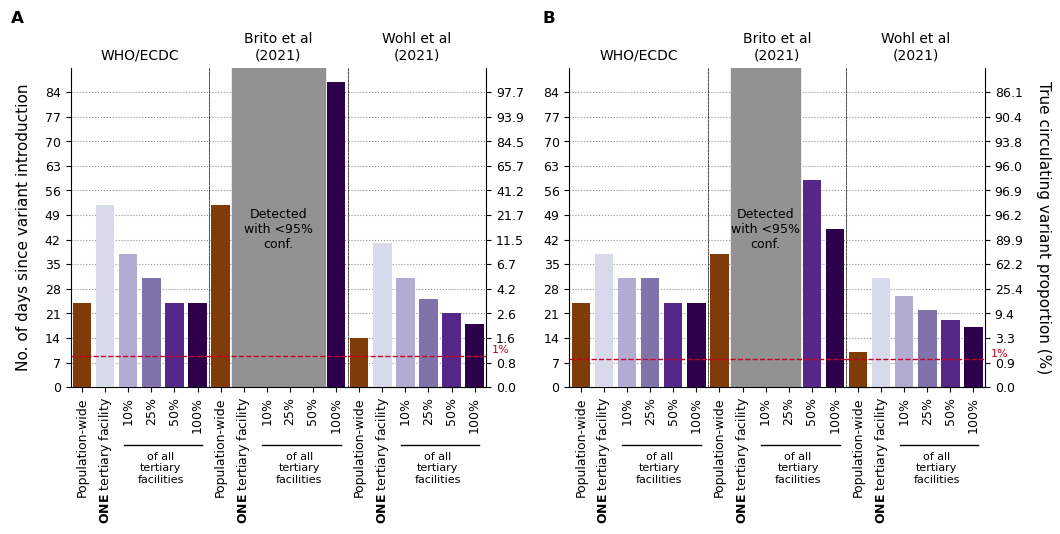

In [10]:
# for 27 tests, plot first detection with 95% probability for different delay 
delay_arr = [0, 3, 7, 14, 21]
delay_cmap = sns.color_palette('YlOrRd', len(delay_arr))
prev_recc_arr = ['Brito et al\n(2021)', 'WHO/ECDC', 'Wohl et al\n(2021)']
recc_idx_arr = [1, 0, 2]

recc_cols = ['#8dd3c7','#bebada','#fb8072']

for j, n_test in enumerate(test_N_arr): 
    with plt.style.context("default"): 
        fig = plt.figure(figsize=(11.8, 8.3 * 0.5))
        gs = GridSpec(nrows=1, ncols=2, wspace=0.2)

        for v, virus in enumerate(var_type_arr): 
            sub_gs = gs[v].subgridspec(nrows=1, ncols=len(prev_recc_arr), wspace=0.)

            mean_true_circ_mt_prop = (all_var_count_arr[v,j,:,:,1] / (all_var_count_arr[v,j,:,:,1] + all_var_count_arr[v,j,:,:,0])).mean(axis=0)

            for recc, recc_label in enumerate(prev_recc_arr):
                recc_idx = recc_idx_arr[recc]
                ax = fig.add_subplot(sub_gs[recc_idx])
                    
                prob95_day_1 = []
                
                seq_n = []
                seq_f = [] 
                
                for seq_mode in seq_mode_arr: 
                    if recc == 2: 
                        first_detection_day_arr = wohl_first_detection[v,j,:,seq_mode]
                    else: 
                        first_detection_day_arr = prev_recc_first_detection[v,j,:,seq_mode,recc]
                    
                    sorted_unique_days = np.sort(np.unique(first_detection_day_arr))
                    prob95_day_prob = np.array([len(first_detection_day_arr[first_detection_day_arr<=day])/len(first_detection_day_arr) for day in sorted_unique_days])
                    
                    """if recc_label == 'Brito et al\n(2021)': 
                        print (seq_mode, sorted_unique_days, prob95_day_prob)"""
                    
                    if v == 0 and recc == 0 and seq_mode == 1: 
                        prob95_day_1.append(sorted_unique_days[prob95_day_prob<0.95][-1])
                    else:
                        prob95_day_1.append(sorted_unique_days[prob95_day_prob>=0.95][0])
                    
                    curr_seq_n_per_week = prev_recc_seq_n_per_week[v,j,:,seq_mode,:,recc]
                    curr_spec_tot_per_week = prev_recc_specimens_tot_per_week[v,j,:,seq_mode,:]

                    curr_seq_f_per_week = curr_seq_n_per_week[curr_spec_tot_per_week>0]/curr_spec_tot_per_week[curr_spec_tot_per_week>0]
                    curr_seq_n_per_week = curr_seq_n_per_week.mean()
                    curr_seq_f_per_week = curr_seq_f_per_week.mean()    
                    
                    seq_n.append(np.around(curr_seq_n_per_week).astype(np.int32))
                    seq_f.append(np.around(curr_seq_f_per_week*100, 1))                    
                    
                prob95_day_1 = np.array(prob95_day_1)
                prob95_day_1[prob95_day_1>=91] = 0
                prob95_day_1 = np.array([prob95_day_1[0]] + list(prob95_day_1[2:]) + [prob95_day_1[1]])
                ax.bar(np.arange(len(prob95_day_1)), prob95_day_1, color=seq_mode_cols, zorder=100)
                
                ax.set_ylim(0., 91)
                ax.set_yticks(np.arange(0, 91, 7))
                ax.set_xlim(-0.5, 5.5)
                ax.set_xticks(np.arange(6))
                ax.tick_params(axis='both', labelsize=9)
                
                if recc == 0: 
                    if v == 0:
                        x2 = 4.5
                    else: 
                        x2 = 3.5
                    ax.fill_betweenx(y=[ax.get_ylim()[0], ax.get_ylim()[-1]], 
                                     x1=0.5, x2=x2, color='#929292')
                    ax.text(s='Detected\nwith <95%\nconf.', x=0.5 + (x2-0.5)/2, y=45, 
                            ha='center', va='center', fontsize=9)
                
                if recc_idx > 0: 
                    ax.set_yticklabels([])
                    ax.tick_params(axis='y', left=False, right=False)
                    ax.spines['left'].set_linewidth(.5)
                    ax.spines['left'].set_linestyle('--')    
                    
                if v == 0 and recc_idx == 0:
                    ax.set_ylabel('No. of days since variant introduction', fontsize=11, labelpad=10)
                
                ax.grid(axis='y', ls='dotted', lw=0.8, c='#929292', zorder=-100)
                for axis in ['top', 'right']: 
                    ax.spines[axis].set_visible(False)

                if recc_idx == 2: 
                    ax2 = ax.twinx()
                    ax.tick_params(axis='y', left=False)
                    for axis in ['top', 'left']: 
                        ax2.spines[axis].set_visible(False)
                    ax2.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1])
                    ax2.set_yticks(ax.get_yticks())
                    ax2.set_yticklabels(np.around(100 * mean_true_circ_mt_prop[ax.get_yticks()], 1), fontsize=9)
                    
                if v == 1 and recc_idx == 2:
                    ax2.set_ylabel('True circulating variant proportion (%)', fontsize=11, rotation=270, labelpad=20)                    

                pc1_day = np.arange(91)[mean_true_circ_mt_prop>=0.01][0]
                ax.axhline(pc1_day, lw=1., ls='--', color='#ca0020',zorder=101)
                if recc_idx == 2:
                    ax.text(s='1%', x=ax.get_xlim()[-1] + 1, 
                            y=pc1_day+3, fontsize=8, ha='right', va='top', color='#ca0020')
                
                ax.set_xticklabels(['Population-wide', r"$\bf{ONE}$" + " tertiary facility", "10%", "25%", "50%", "100%"], 
                                   rotation=90, ha='center') 
                ax.tick_params(axis='both', labelsize=9)
                ax.set_title(recc_label, fontsize=10)
        
                ax.plot([1.8,5.2],[-0.18,-0.18], lw=1., color="k", transform=ax.get_xaxis_transform(), clip_on=False)
                ax.text(s='of all\ntertiary\nfacilities', x=2.4 + (2.4-0.4)/2, y = -23, ha='center', va='center', fontsize=8, )

        #fig.text(s=r"$\bf{WT/Alpha}$", x=0.3, y=1.02, ha='center', va='center', fontsize=12)
        #fig.text(s=r"$\bf{Delta/Omicron}$", x=0.71, y=1.02, ha='center', va='center', fontsize=12)        
        
        fig.text(s=r"$\bf{A}$", x=0.08, y=1., fontsize=12, ha='center', va='center')
        fig.text(s=r"$\bf{B}$", x=0.53, y=1., fontsize=12, ha='center', va='center')
        
        plt.savefig('./gs_manuscript/figure2.png', dpi=330, bbox_inches='tight')
        #plt.savefig('./gs_manuscript/figure2.pdf', bbox_inches='tight')        
        
        plt.show()
        break 

## Read results of GS simulations 

In [11]:
results_df = []
delay = 7

for virus in var_type_arr: 
    if virus == 'alpha':
        f_mutant_beta = 1.8
    else: 
        f_mutant_beta = 3.0
    var_summary_df = summary_df[(summary_df['virus']==virus)&(summary_df['f_mutant_beta']==f_mutant_beta)].copy()
    
    for set_id in np.sort(var_summary_df['set_id'].unique()): 
        ntest_var_summary_df = var_summary_df[var_summary_df['set_id']==set_id]
        n_test = ntest_var_summary_df['number_of_rdt_per_100k_per_day'].unique()[0]

        for seq_prop in seq_prop_arr: 
            first_dection_arr = np.zeros((1000, 8), dtype=float)
            max_abs_diff_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode  
            gmean_abs_diff_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode           
            prop_days_abs_diff_abv20_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode
            prop_days_w_measurement = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode
            
            for run_id in np.arange(10): 
                # get true rel proportions                 
                set_run_row = ntest_var_summary_df[ntest_var_summary_df['run_id']==run_id]
                wt_infectious_arr = np.array(set_run_row['wt_infectious_arr'].iloc[0])/1e6
                mt_infectious_arr = np.array(set_run_row['mt_infectious_arr'].iloc[0])/1e6
                rel_mt_inf_prop_arr = mt_infectious_arr/(wt_infectious_arr + mt_infectious_arr)
                
                # get simulation results 
                if virus == 'alpha': 
                    fname = "./PATAT_gs_ms_data/20220208_alpha_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop)
                else: 
                    fname = "./PATAT_gs_ms_data/20220208_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop)
                try: 
                    result_arr = np.load(fname)
                except: 
                    continue 
                var_seq_arr = result_arr['var_seq_arr']
                
                # for each simulation 
                for idx in np.arange(100):
                    sim_i = run_id * 100 + idx
                    # find first detection day 
                    curr_day_arr, curr_seq_mode_arr = np.where(var_seq_arr[idx,:,:,1] > 0)
                    first_dection_arr[sim_i] = [curr_day_arr[curr_seq_mode_arr==seq_mode].min() if len(curr_day_arr[curr_seq_mode_arr==seq_mode]) > 0 else 91 for seq_mode in np.arange(8)]
                    # get largest difference in measured and true variant proportion 
                    for seq_mode in np.arange(8): 
                        sim_seq_arr = var_seq_arr[idx,:,seq_mode,:]

                        sim_seq_day_range = np.arange(delay, 91, delay)
                        sim_seq_n_arr = np.array([sim_seq_arr[day-delay:day,:].sum() for day in sim_seq_day_range])
                        sim_seq_mask = sim_seq_n_arr > 0
                        sim_seq_day_range = sim_seq_day_range[sim_seq_mask]
                        
                        # get maximum error between measured and circulating variant proportion
                        mean_rel_mt_prop = np.array([rel_mt_inf_prop_arr[day-delay:day].mean() for day in sim_seq_day_range])
                        mean_rel_mt_seq = np.array([sim_seq_arr[day-delay:day,1].sum()/sim_seq_arr[day-delay:day,:].sum() for day in sim_seq_day_range])
                        
                        mean_abs_err = np.abs(mean_rel_mt_seq-mean_rel_mt_prop)
                        gmean_abs_diff_arr[sim_i, seq_mode] = np.prod(mean_abs_err)**(1/len(mean_abs_err))
                        max_abs_diff_arr[sim_i, seq_mode] = np.max(mean_abs_err)
                        
                        prop_days_w_measurement[sim_i, seq_mode] = len(mean_abs_err)/90
                        prop_days_abs_diff_abv20_arr[sim_i, seq_mode] = len(mean_abs_err[mean_abs_err>0.2])/len(mean_abs_err)
                        
            for seq_mode, idx in enumerate([0, 4, 5, 6, 7, 2]):
                sm_first_dection_arr = first_dection_arr[:,idx]
                prop_not_detected = len(sm_first_dection_arr[sm_first_dection_arr>=91])/len(sm_first_dection_arr)
                
                # get day under which variant will be detected with 95% confidence 
                detected_sm_first_dection_arr = sm_first_dection_arr[sm_first_dection_arr<91]
                sm_first_detection_prob = np.array([len(detected_sm_first_dection_arr[detected_sm_first_dection_arr<=day])/len(sm_first_dection_arr) for day in np.sort(np.unique(sm_first_dection_arr))])
                
                prob95_day = np.where(sm_first_detection_prob>=0.95)[0][0]
                expected_day = np.mean(sm_first_dection_arr)
                sd_expected_day = np.std(sm_first_dection_arr, ddof=1)
                
                results_df.append({'virus':virus, 'n_test':n_test, 'seq_prop':seq_prop, 'seq_mode':seq_mode, 
                                   'prob_not_detected':prop_not_detected * 100,
                                   'expected_day_1':expected_day, 'sd_expected_day':sd_expected_day, 'prob95_day_1':prob95_day, 
                                   'max_diff':max_abs_diff_arr[:,idx].mean() * 100, 
                                   'gmean_err':gmean_abs_diff_arr[:,idx].mean() * 100,
                                   'prop_days_w_mea':prop_days_w_measurement[:,idx].mean() * 100, 
                                   'prop_days_abv20_absdiff':prop_days_abs_diff_abv20_arr[:,idx].mean() * 100})

results_df = pd.DataFrame.from_dict(results_df)
results_df.head()

,virus,n_test,seq_prop,seq_mode,prob_not_detected,expected_day_1,sd_expected_day,prob95_day_1,max_diff,gmean_err,prop_days_w_mea,prop_days_abv20_absdiff
0,alpha,27,1,0,0.0,34.539,12.021356,38,48.450396,4.924891,12.181111,18.095000
1,alpha,27,1,1,0.0,44.345,17.889942,45,43.800220,5.971696,9.890000,18.719802
2,alpha,27,1,2,0.0,35.816,13.719853,44,48.231108,5.302687,11.800000,19.227828
3,alpha,27,1,3,0.0,33.938,11.833097,38,50.455329,5.245816,12.096667,19.266836
4,alpha,27,1,4,0.0,34.280,11.895003,38,49.955292,5.184966,12.193333,19.285354


## Detection operating curves

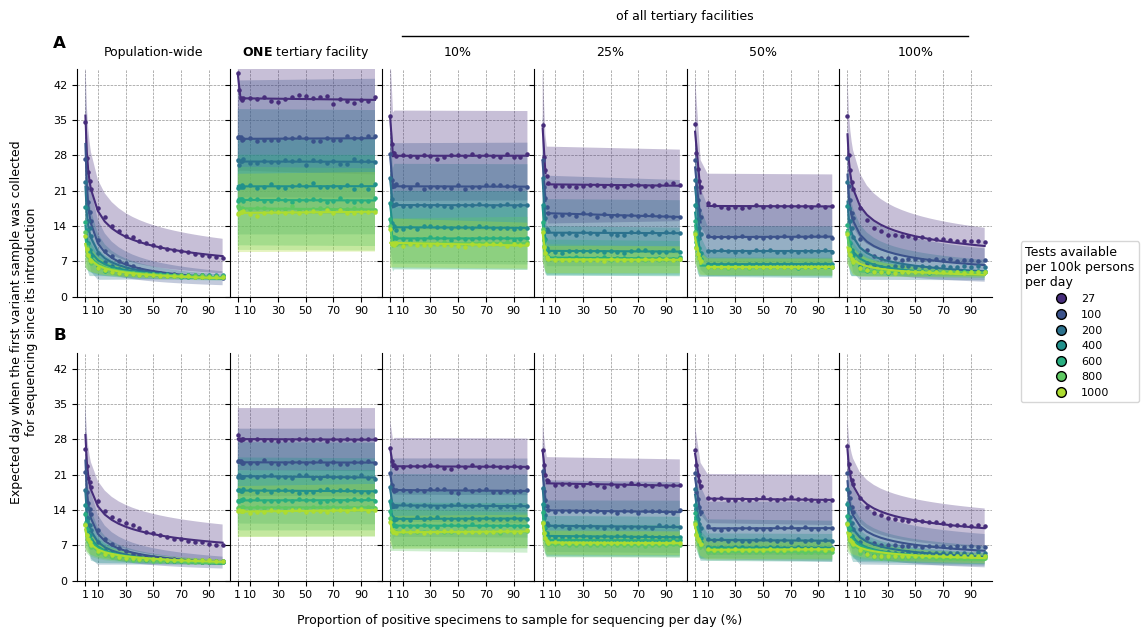

In [12]:
seq_mode_labels = ['Population-wide', r"$\bf{ONE}$" + " tertiary facility", "10%", "25%", "50%", "100%"]

def linear_func(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def compute_r_squared(residuals, y): 
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res / ss_tot)

def two_phase_linear(x, y):
    
    i_to_r2 = {}
    i_to_popt = {}
    
    for i in np.arange(3, len(x)-2): 
        if x[i] > 20: 
            break
        
        popt_1, pcov_1 = curve_fit(linear_func, x[:i], y[:i]) # your data x, y to fit
        popt_2, pcov_2 = curve_fit(linear_func, x[i:], y[i:]) # your data x, y to fit
        y_pred = list(linear_func(x[:i], *popt_1)) + list(linear_func(x[i:], *popt_2))
        residuals = y - y_pred
        r2 = compute_r_squared(residuals, y)
        if r2 > 0.8:
            i_to_r2[i] = r2
            i_to_popt[i] = (i, popt_1, popt_2)
    
    if len(i_to_popt) > 0: 
        return i_to_popt[max(i_to_r2, key=i_to_r2.get)]
    else: 
        popt_1, pcov_1 = curve_fit(linear_func, x, y)
        return 0, popt_1, None

test_cmap = sns.color_palette('viridis', len(test_N_arr))

with plt.style.context('default'): 
    fig = plt.figure(figsize=(11.8, 8.3 * 0.8))
    gs = GridSpec(nrows=2, ncols=6, wspace=0., hspace=0.25)

    for v, virus in enumerate(['alpha', 'omicron']): 
        virus_results_df = results_df[results_df['virus']==virus]
    
        for seq_mode in np.arange(6): 
            ax = fig.add_subplot(gs[v, seq_mode])
            
            sm_virus_results_df = virus_results_df[virus_results_df['seq_mode']==seq_mode].copy().set_index('n_test')
            for n, n_test in enumerate(test_N_arr):
                x_data = sm_virus_results_df.loc[n_test, 'seq_prop'].to_numpy()
                y_data = sm_virus_results_df.loc[n_test, 'expected_day_1'].to_numpy()
                y_sd_data = sm_virus_results_df.loc[n_test, 'sd_expected_day'].to_numpy()
                ax.scatter(x_data, y_data, color=test_cmap[n], marker='.', s=20, zorder=100)
                
                popt, pcov = curve_fit(linear_func, np.log(x_data), np.log(y_data)) # your data x, y to fit
                negpos_residuals = np.log(y_data) - linear_func(np.log(x_data), *popt)
                negpow_r2 = compute_r_squared(negpos_residuals, np.log(y_data))
                if negpow_r2 > 0.85: 
                    m, c = popt
                    ax.plot(x_data, np.exp(m * np.log(x_data) + c), color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                else: 
                    i, popt_1, popt_2 = two_phase_linear(x_data, y_data)
                    if i > 0: 
                        ax.plot(x_data[:i], popt_1[0] * x_data[:i] + popt_1[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                        ax.plot(x_data[i:], popt_2[0] * x_data[i:] + popt_2[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                    else: 
                        ax.plot(x_data, popt_1[0] * x_data + popt_1[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                
                y_sd_arr = []
                for yy in [y_data - y_sd_data, y_data + y_sd_data]:
                    popt, pcov = curve_fit(linear_func, np.log(x_data), np.log(yy)) # your data x, y to fit
                    negpos_residuals = np.log(yy) - linear_func(np.log(x_data), *popt)
                    negpow_r2 = compute_r_squared(negpos_residuals, np.log(yy))
                    if negpow_r2 > 0.85: 
                        m, c = popt
                        y_sd_arr.append(np.exp(m * np.log(x_data) + c))
                    else: 
                        i, popt_1, popt_2 = two_phase_linear(x_data, yy)
                        if i > 0: 
                            y_sd_arr.append(np.array(list(popt_1[0] * x_data[:i] + popt_1[-1]) + list(popt_2[0] * x_data[i:] + popt_2[-1]))) 
                        else: 
                            y_sd_arr.append(popt_1[0] * x_data + popt_1[-1])
                ax.fill_between(x = x_data, y1 = y_sd_arr[0], y2 = y_sd_arr[1], 
                                interpolate=True, facecolor=test_cmap[n], edgecolor=None, zorder=50, alpha=0.3)
                #break
                    
            ax.set_ylim(0., 45.)
            ax.set_yticks(np.arange(0, 45, 7))
            if seq_mode > 0: 
                ax.set_yticklabels([])
            ax.grid(axis='both', ls='--', lw=0.5, color='#929292', zorder=-100)
            ax.set_xticks([1] + list(np.arange(10, 110, 20)))
            ax.set_xlim(-5, 105)
            ax.tick_params(axis='both', labelsize=8)
            
            for axis in ['top', 'right']: 
                ax.spines[axis].set_visible(False)
            
            if v == 0:
                ax.set_title(seq_mode_labels[seq_mode], fontsize=9, pad=10)
                
    fig.text(s='Proportion of positive specimens to sample for sequencing per day (%)', x=0.5, y=0.05, 
             ha='center', va='center', fontsize=9)
    fig.text(s='Expected day when the first variant sample was collected\nfor sequencing since its introduction', x=0.08, y=0.5, 
             ha='center', va='center', fontsize=9, rotation=90)

    line = plt.Line2D([.4, .88], [.93, .93], linewidth=1., transform=fig.transFigure, color="black")
    fig.add_artist(line)
    fig.text(s='of all tertiary facilities', x=0.4 + (.48/2), y = .95, ha='center', va='bottom', fontsize=9, )
    # legend 
    legend_handles = []
    for t, test_N in enumerate(test_N_arr): 
        legend_handles.append(Line2D([0], [0], marker='o', color='k', lw=0., label=test_N,
                              markerfacecolor=test_cmap[t], markersize=7))
    legend = fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(.92, 0.5), fontsize=8,
                        title="Tests available\nper 100k persons\nper day")
    legend.get_title().set_fontsize('9')
    
    fig.text(s=r"$\bf{A}$", x=0.11, y=.92, fontsize=12, ha='center', va='center')
    fig.text(s=r"$\bf{B}$", x=0.11, y=.48, fontsize=12, ha='center', va='center')
    
    plt.savefig('./gs_manuscript/figure3.png', dpi=330, bbox_inches='tight')
    #plt.savefig('./gs_manuscript/figure3.pdf', bbox_inches='tight')
    
    plt.show()

## Variant accuracy and precision

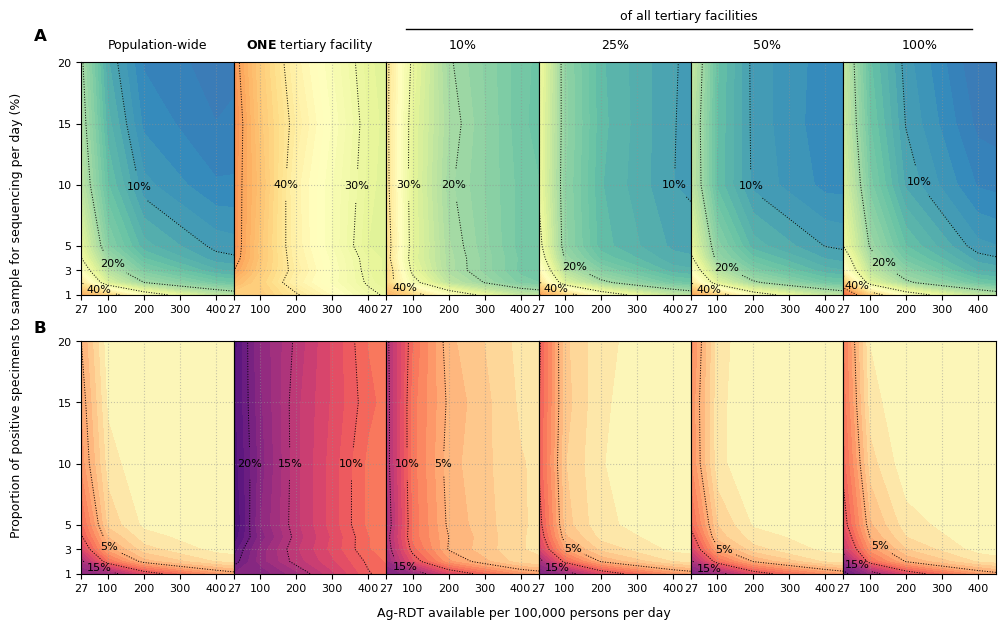

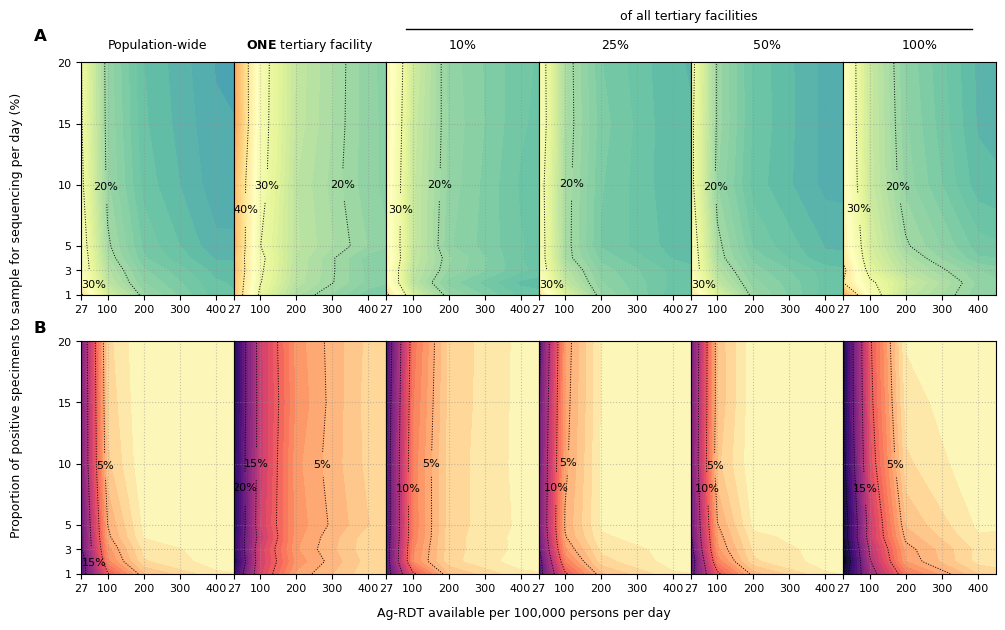

In [13]:
def plot_contour_plots(lidx, label, virus):
    for seq_mode in np.arange(6): 
        ax = fig.add_subplot(gs[lidx, seq_mode])

        sm_virus_results_df = virus_results_df[virus_results_df['seq_mode']==seq_mode].copy()#.set_index('n_test')
        #print (virus_results_df[label].min(), virus_results_df[label].max())

        fdf = sm_virus_results_df[['n_test', 'seq_prop', label]]
        x = np.sort(fdf['n_test'].unique())
        y = np.sort(fdf['seq_prop'].unique())
        X, Y = np.meshgrid(x, y)
        Z = fdf.pivot('n_test', 'seq_prop').to_numpy()
        
        if label == 'max_diff':
            levels = np.linspace(0., 70, 71) 
            cf = ax.contourf(X, Y, Z.T, cmap='Spectral_r', levels=levels) ##, levels=np.linspace(0,0.5,51))
            levels = np.linspace(0., 60, 7) 
            cp = ax.contour(X, Y, Z.T, colors='k', linestyles='dotted', linewidths=0.7, levels=levels)
            
        else:
            levels = np.linspace(0., 30, 31) 
            cf = ax.contourf(X, Y, Z.T, cmap='magma_r', levels=levels) ##, levels=np.linspace(0,0.5,51))
            levels = np.linspace(5, 30, 6) 
            cp = ax.contour(X, Y, Z.T, colors='k', linestyles='dotted', linewidths=0.7, levels=levels)
            
        ax.set_ylim(1, 20)
        ax.set_yticks([1, 3] + list(np.arange(5,25,5)))
        if seq_mode > 0: 
            ax.set_yticklabels([])
            ax.tick_params(axis='y', left=False)
        ax.set_xlim(27, 450)
        ax.set_xticks([27, 100, 200, 300, 400])
        ax.grid(axis='both', ls='dotted', lw=0.8, c='#929292', alpha=0.5)

        ax.tick_params(axis='both', labelsize=8)
        
        if label == 'max_diff':
            manual_locations = {('alpha',0):[(200,10), (100,3), (70,1)], 
                                ('alpha',1):[(180,10), (350,10)],
                                ('alpha',2):[(100,10), (200,10), (70,1)],
                                ('alpha',3):[(400,10), (120,3), (70,1)],                                 
                                ('alpha',4):[(200,10), (120,3), (70,1)], 
                                ('alpha',5):[(200,10), (120,3), (70,2)], 
                                ('omicron',0):[(200,10), (70,2)], 
                                ('omicron',1):[(50,8), (100,10), (300,10)], 
                                ('omicron',2):[(50,8), (200,10),], 
                                ('omicron',3):[(70,2), (200,10)], 
                                ('omicron',4):[(70,2), (200,10)], 
                                ('omicron',5):[(50,8), (200,10)]}
            
        else: 
            manual_locations = {('alpha',0):[(100,3), (70,1)], 
                                ('alpha',1):[(50,10), (180,10), (350,10)],
                                ('alpha',2):[(100,10), (200,10), (70,1)],
                                ('alpha',3):[(120,3), (70,1)],                                 
                                ('alpha',4):[(120,3), (70,1)], 
                                ('alpha',5):[(120,3), (70,2)], 
                                ('omicron',0):[(200,10), (70,2)], 
                                ('omicron',1):[(50,8), (100,10), (300,10)], 
                                ('omicron',2):[(100,8), (200,10),], 
                                ('omicron',3):[(80,8), (200,10)], 
                                ('omicron',4):[(80,8), (200,10)], 
                                ('omicron',5):[(100,8), (200,10)]}
        
        try: 
            ct = ax.clabel(cp, colors='k', fontsize=8, inline=1, inline_spacing=4, fmt="%i%%", 
                           manual=manual_locations[(virus,seq_mode)],)
        except: 
            ct = ax.clabel(cp, colors='k', fontsize=8, inline=1, inline_spacing=4, fmt="%i%%")

        for l in ct:
            l.set_rotation(0)
            
        if lidx == 0: 
            ax.set_title(seq_mode_labels[seq_mode], fontsize=9, pad=10)

for virus in ['alpha', 'omicron']: 
    virus_results_df = results_df[results_df['virus']==virus]
    
    with plt.style.context("default"): 
        fig = plt.figure(figsize=(11.8, 8.3 * 0.8))
        gs = GridSpec(nrows=2, ncols=6, wspace=0., hspace=0.2)
        
        for lidx, label in enumerate(['max_diff', 'prop_days_abv20_absdiff',]): # 'prop_days_w_mea'
            plot_contour_plots(lidx, label, virus)
            
        line = plt.Line2D([.4, .88], [.93, .93], linewidth=1., transform=fig.transFigure, color="black")
        fig.add_artist(line)
        
        fig.text(s='of all tertiary facilities', x=0.4 + (.48/2), y = .94, ha='center', va='bottom', fontsize=9, )
        fig.text(s='Ag-RDT available per 100,000 persons per day', x=0.5, y=0.05, fontsize=9, ha='center', va='center')
        fig.text(s='Proportion of positive specimens to sample for sequencing per day (%)', x=0.07, y=0.5, 
                 rotation=90, fontsize=9, ha='center', va='center')
        
        fig.text(s=r"$\bf{A}$", x=0.09, y=.92, fontsize=12, ha='center', va='center')
        fig.text(s=r"$\bf{B}$", x=0.09, y=.48, fontsize=12, ha='center', va='center')
        
        if virus == 'alpha': 
            plt.savefig('./gs_manuscript/figure4.png', dpi=330, bbox_inches='tight')
            #plt.savefig('./gs_manuscript/figure4.pdf', bbox_inches='tight')
        else: 
            plt.savefig('./gs_manuscript/figureS1.png', dpi=330, bbox_inches='tight')
        
        plt.show()

## Our four-step reccomendation

In [14]:
delay_cmap = sns.color_palette('YlOrRd', len(delay_arr))
delay_arr = [0, 3, 7, 14, 21]

sm_to_idx = {seq_mode:idx for seq_mode, idx in enumerate([0, 4, 5, 6, 7, 2])}

actual_detect_day1 = {}
for virus in var_type_arr: 
    if virus == 'alpha':
        f_mutant_beta = 1.8
    else: 
        f_mutant_beta = 3.0
    var_summary_df = summary_df[(summary_df['virus']==virus)&(summary_df['f_mutant_beta']==f_mutant_beta)].copy()
    
    for set_id in np.sort(var_summary_df['set_id'].unique()): 
        ntest_var_summary_df = var_summary_df[var_summary_df['set_id']==set_id]
        n_test = ntest_var_summary_df['number_of_rdt_per_100k_per_day'].unique()[0]

        for seq_prop in seq_prop_arr: 
            
            first_dection_arr = np.zeros((1000, 6, len(delay_arr)), dtype=float)
            mean_seq_per_week_arr = np.zeros((1000, 6, len(delay_arr)), dtype=float)
            
            for run_id in np.arange(10): 
                # get true rel proportions                 
                set_run_row = ntest_var_summary_df[ntest_var_summary_df['run_id']==run_id]
                wt_infectious_arr = np.array(set_run_row['wt_infectious_arr'].iloc[0])/1e6
                mt_infectious_arr = np.array(set_run_row['mt_infectious_arr'].iloc[0])/1e6
                rel_mt_inf_prop_arr = mt_infectious_arr/(wt_infectious_arr + mt_infectious_arr)
                
                # get simulation results 
                if virus == 'alpha': 
                    result_arr = np.load("./PATAT_gs_ms_data/20220208_alpha_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop))
                else: 
                    result_arr = np.load("./PATAT_gs_ms_data/20220208_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop))
                    #print ("./20220208_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop))
                var_seq_arr = result_arr['var_seq_arr']
                
                # for each simulation 
                for idx in np.arange(100):
                    sim_i = run_id * 100 + idx
                    
                    for seq_mode in np.arange(6):
                        curr_var_seq_arr = var_seq_arr[idx,:,sm_to_idx[seq_mode],:]
                        
                        found_day_1 = 0
                        n_seq_per_week = []
                        for d, day in enumerate(seq_day_arr): 
                            if d > 0: 
                                week_arr = np.arange(seq_day_arr[d-1], day)
                            else: 
                                week_arr = np.arange(0, day)
                            
                            week_var_seq_arr = curr_var_seq_arr[week_arr,:]
                            if (found_day_1 == 0) and (week_var_seq_arr[:,1].sum() > 0): 
                                first_dection_arr[sim_i,seq_mode,:] = day + delay_arr
                                found_day_1 = 1
                            
                            if len(week_arr) == 7: 
                                n_seq_per_week.append(week_var_seq_arr.sum())
                        mean_seq_per_week_arr[sim_i,seq_mode,:] = np.mean(n_seq_per_week)
            
            expected_first_detection = first_dection_arr.mean(axis=0)
            sd_expected_day = first_dection_arr.std(axis=0, ddof=1)
            prob95_first_detection = np.zeros(expected_first_detection.shape, dtype=float)
            
            mean_seq_per_week = mean_seq_per_week_arr.mean(axis=0)
            
            for seq_mode in np.arange(6): 
                for d, delay in enumerate(delay_arr): 
                    sm_delay_first_detect_arr = first_dection_arr[:,seq_mode,d]
                    sm_delay_first_detect_prob = np.array([len(sm_delay_first_detect_arr[sm_delay_first_detect_arr<=day])/len(sm_delay_first_detect_arr) for day in np.sort(np.unique(sm_delay_first_detect_arr))])
                    prob95_first_detection[seq_mode, d] = np.sort(np.unique(sm_delay_first_detect_arr))[sm_delay_first_detect_prob>=0.95][0]
            
            try: 
                actual_detect_day1[virus][n_test][seq_prop] = {'expected':expected_first_detection, 'sd':sd_expected_day, 'prob95':prob95_first_detection, 'mean_seq_per_week':mean_seq_per_week}
            except: 
                try: 
                    actual_detect_day1[virus][n_test] = {seq_prop:{'expected':expected_first_detection, 'sd':sd_expected_day, 'prob95':prob95_first_detection, 'mean_seq_per_week':mean_seq_per_week}}
                except: 
                    actual_detect_day1[virus] = {n_test:{seq_prop:{'expected':expected_first_detection, 'sd':sd_expected_day, 'prob95':prob95_first_detection, 'mean_seq_per_week':mean_seq_per_week}}}

29.025999999999996 0.04267370458000913


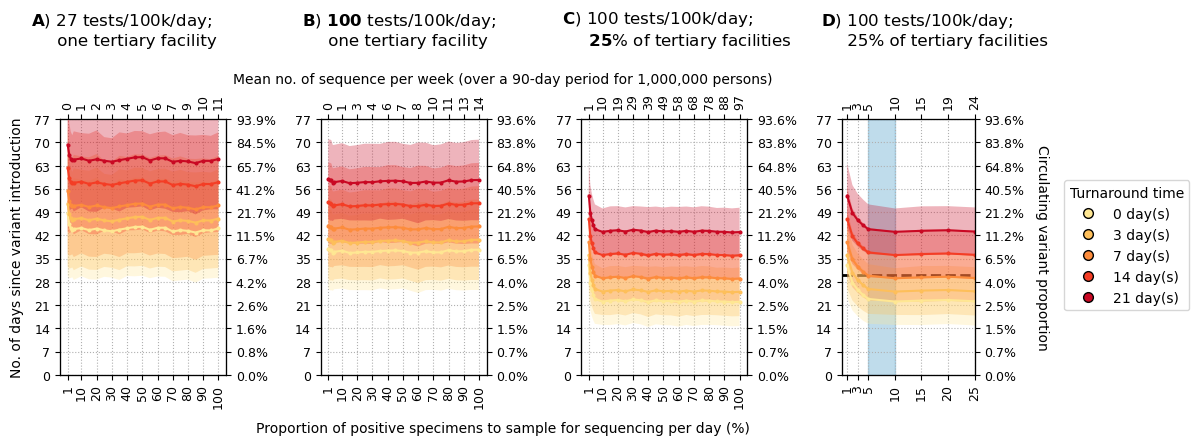

27.331999999999997 0.22705039683920275


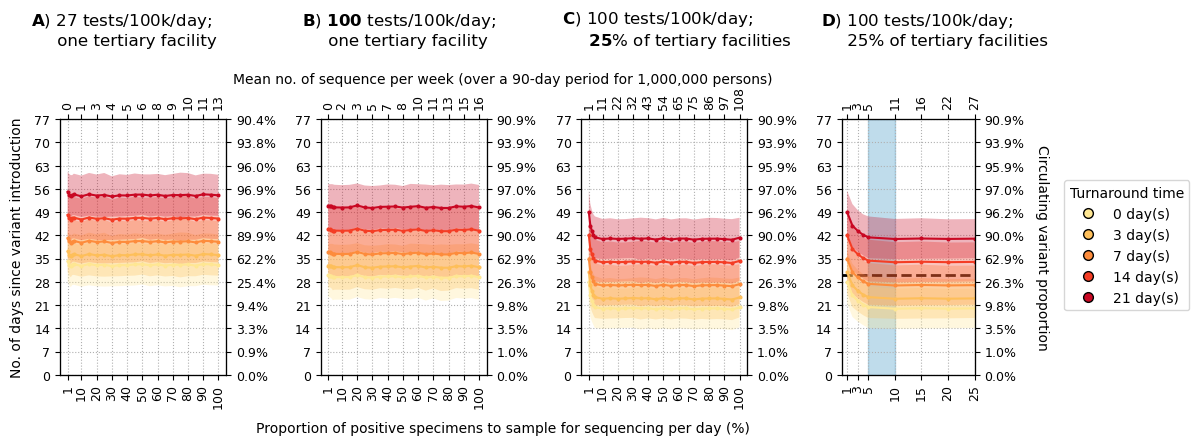

In [15]:
def linear_func(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B
    
sm_to_idx = {seq_mode:idx for seq_mode, idx in enumerate([0, 2, 3, 4, 5, 1])}

def plot_ax(ax, n_test = 200, seq_mode = 3, virus = 'alpha', ax_id=0): 
    
    n = test_N_arr.index(n_test)
    f_mutant_beta = 1.8 if virus == 'alpha' else 3.0
    fdf_summary = summary_df[(summary_df['number_of_rdt_per_100k_per_day']==n_test)&(summary_df['virus']==virus)&(summary_df['f_mutant_beta']==f_mutant_beta)].copy()
    all_mt_arr = np.zeros((10, 91), dtype=float)
    for r, row in fdf_summary.iterrows(): 
        mt_arr = np.array(row['mt_infectious_arr'])  #np.array(row['mt_exp_arr']) + np.array(row['mt_exp_arr'])
        wt_arr = np.array(row['wt_infectious_arr'])  #np.array(row['wt_exp_arr']) + np.array(row['wt_exp_arr'])
        all_mt_arr[row['run_id']] = mt_arr/(mt_arr+wt_arr)
    mean_mt_arr = all_mt_arr.mean(axis=0)

    for d, delay in enumerate(delay_arr): 

        x = np.sort(list(actual_detect_day1[virus][n_test].keys()))
        y = np.array([actual_detect_day1[virus][n_test][seq_prop]['expected'][seq_mode,d] for seq_prop in x])
        y_sd = np.array([actual_detect_day1[virus][n_test][seq_prop]['sd'][seq_mode,d] for seq_prop in x])
        y_low = y - y_sd
        y_high = y + y_sd
        
        y = np.log(y)
        x = np.log(x)
        # fit line 
        popt, pcov = curve_fit(linear_func, x, y) # your data x, y to fit
        m, c = popt

        ax.scatter(np.exp(x), np.exp(y), color=delay_cmap[d], zorder=100, marker='.', s=15)
        ax.plot(np.exp(x), np.exp(y), color=delay_cmap[d], lw=1.5, zorder=100,)# marker='.', s=15)
        #ax.plot(np.exp(x), np.exp(m * x + c), color=delay_cmap[d], zorder=100, lw = 1.5)
        ax.fill_between(x = np.exp(x), y1 = y_low, y2 = y_high, 
                        interpolate=True, facecolor=delay_cmap[d], edgecolor=None, zorder=50, alpha=0.3)
        
        if ax_id == 3 and delay == 7:
            last_day = np.exp(y)[-1]

    ax.set_yticks(np.arange(0, 77+7, 7))
    ax.set_ylim(0., 77)
    if ax_id == 3: 
        ax.set_xticks([1, 3, 5, 10, 15, 20, 25])
        ax.set_xlim(0, 25)
    else: 
        ax.set_xticks([1] + list(np.arange(10, 110, 10)))
        ax.set_xlim(-4, 105)
    ax.grid(axis='both', ls='dotted', lw=0.8, zorder=-100)
    ax.tick_params(axis='both', labelsize=9)
    ax.tick_params(axis='x', rotation=90)

    ax2 = ax.twinx()
    ax2.set_yticks(np.arange(0, 77+7, 7))
    ax2.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1])
    ax2.set_yticklabels(["%.1f%%"%(f*100) for f in mean_mt_arr[np.arange(0, 77+7, 7)]])
    ax2.tick_params(axis='both', labelsize=9)
    if ax_id == 3:
        print (last_day, mean_mt_arr[np.around(last_day).astype(np.int32)])
    
    v = 0 if virus == 'alpha' else 1
    tot_recc_specimens = prev_recc_specimens_tot_per_week[v,n,:,sm_to_idx[seq_mode],:]
    y_seq = []
    for seq_prop in seq_prop_arr: 
        y_seq.append((seq_prop/100 * tot_recc_specimens[tot_recc_specimens>0]).mean())
    y_seq = np.array(y_seq)

    ax3 = ax.twiny()
    ax3.set_xticks(ax.get_xticks())
    ax3.set_xticklabels(np.around(y_seq[np.isin(seq_prop_arr, ax.get_xticks())], 0).astype(np.int32), 
                        rotation=90)
    ax3.set_xlim(ax.get_xlim()[0], ax.get_xlim()[-1])
    ax3.tick_params(axis='both', labelsize=9,)
    
    if ax_id == 0:
        ax.set_ylabel('No. of days since variant introduction', fontsize=10, ha='center', va='center', labelpad=12.5)
    if ax_id == 3: 
        ax2.set_ylabel('Circulating variant proportion', fontsize=10, ha='center', va='center', rotation=270, labelpad=12.5)
        ax.axhline(30, ls='--', lw=2., color='k')
        ax.fill_betweenx(y=[ax.get_ylim()[0], ax.get_ylim()[-1]], 
                         x1=5, x2=10, color="#2b8cbe", alpha=0.3)
    return 

for virus in ['alpha', 'omicron']:
    with plt.style.context('default'):
        fig = plt.figure(figsize=(11.8, 8.3 * 0.4))
        gs = GridSpec(nrows=1, ncols=4, wspace=0.6, width_ratios=[1, 1, 1, 0.8])

        ax = fig.add_subplot(gs[0])
        plot_ax(ax, n_test = 27, seq_mode = 1, virus = virus, ax_id=0)

        ax = fig.add_subplot(gs[1])
        plot_ax(ax, n_test = 100, seq_mode = 1, virus = virus, ax_id=1)

        ax = fig.add_subplot(gs[2])
        plot_ax(ax, n_test = 100, seq_mode = 3, virus = virus, ax_id=2)

        ax = fig.add_subplot(gs[3])
        plot_ax(ax, n_test = 100, seq_mode = 3, virus = virus, ax_id=3)

        # legend 
        legend_handles = []
        for d, delay in enumerate(delay_arr): 

            legend_handles.append(Line2D([0], [0], marker='o', color='k', lw=0., label="%i day(s)"%(delay),
                                  markerfacecolor=delay_cmap[d], markersize=7))
        legend = fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(.97, 0.5), fontsize=10,
                            title="Turnaround time")
        legend.get_title().set_fontsize('10')

        #ax.axhline(28, ls='--', lw=2., color='k')

        fig.text(s='Proportion of positive specimens to sample for sequencing per day (%)',
                 x = 0.5, y = -0.05, fontsize=10, ha='center', va='center')
        fig.text(s='Mean no. of sequence per week (over a 90-day period for 1,000,000 persons)', 
                 x = 0.5, y = 1., fontsize=10, ha='center', va='center')

        fig.text(s=r"$\bf{A}$" + ") 27 tests/100k/day;\n     one tertiary facility", x=0.1, y=1.15, fontsize=12, ha='left', va='center')
        fig.text(s=r"$\bf{B}$" + ") " + r"$\bf{100}$" + " tests/100k/day;\n     one tertiary facility", x=0.33, y=1.15, fontsize=12, ha='left', va='center')
        fig.text(s=r"$\bf{C}$" + ") 100 tests/100k/day;\n     " + r"$\bf{25}$%" + " of tertiary facilities", x=0.55, y=1.15, fontsize=12, ha='left', va='center')
        fig.text(s=r"$\bf{D}$" + ") 100 tests/100k/day;\n     " + "25% of tertiary facilities", x=0.77, y=1.15, fontsize=12, ha='left', va='center')
        
        if virus == 'alpha':
            plt.savefig('./gs_manuscript/figure6.png', dpi=330, bbox_inches='tight')
            #plt.savefig('./gs_manuscript/figure6.pdf', bbox_inches='tight')            
        else:
            plt.savefig('./gs_manuscript/figureS5.png', dpi=330, bbox_inches='tight')
        plt.show()

## Sensitivity analyses I - varying variant growth rates

In [16]:
summary_df = []
for ini_immune, summary_folder in zip([10, 40], ['./PATAT_gs_ms_data/20220201_surv_summary', 
                                                 './PATAT_gs_ms_data/20220227_surv_summary']):
    for fname in os.listdir(summary_folder): 
        # load and read json 
        with gzip.open("%s/%s"%(summary_folder, fname), "r") as f:
            data = f.read()
            row = json.loads(data.decode('utf-8'))

        row['ini_immune'] = ini_immune
        # get f_mutant_beta 
        f_mutant_beta = row['f_mutant_beta']
        summary_df.append(row)
        
summary_df = pd.DataFrame.from_dict(summary_df)
summary_df.head()

,init_mt_prop,init_immune_prop,f_mutant_beta,number_of_rdt_per_100k_per_day,nc_demand,fpath,set_id,run_id,weekdays_arr,sus_arr,...,mt_infectious_arr,diagnosed_var_arr,diagnosed_agents_arr,diagnosed_day_arr,diagnosed_hcf_arr,all_hcf_n,falpos_agents_arr,falpos_day_arr,falpos_hcf_arr,ini_immune
0,0.0001,0.1,4.0,600,1,./20220201_surv_detect/surv_baseline_set034,34,3,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[885265, 880303, 874628, 869236, 863767, 85625...",...,"[0.0, 0.0, 8.0, 40.0, 78.0, 98.0, 137.0, 197.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[18, 27, 30, 83, 184, 200, 207, 209, 214, 241,...","[17, 10, 4, 24, 24, 7, 2, 11, 17, 2, 31, 5, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[28234, 193928, 209245, 227442, 446037, 484626...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[4, 27, 29, 32, 63, 69, 84, 85, 86, 89, 119, 0...",10
1,0.0001,0.1,1.0,400,1,./20220201_surv_detect/surv_baseline_set021,21,3,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[885343, 880322, 874536, 869124, 863582, 85649...",...,"[0.0, 0.0, 10.0, 39.0, 67.0, 89.0, 96.0, 108.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[30, 32, 36, 94, 106, 121, 187, 201, 203, 207,...","[4, 17, 38, 17, 24, 17, 17, 10, 6, 1, 6, 31, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[41751, 196301, 211407, 223401, 399013, 441056...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[5, 28, 30, 31, 57, 63, 76, 78, 78, 82, 111, 1...",10
2,0.0001,0.1,1.8,600,1,./20220201_surv_detect/surv_baseline_set031,31,1,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[888958, 887821, 886199, 883133, 878068, 87157...",...,"[0.0, 0.0, 12.0, 37.0, 67.0, 92.0, 116.0, 145....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[13, 25, 35, 37, 49, 86, 107, 164, 169, 198, 2...","[24, 24, 31, 38, 24, 7, 31, 24, 31, 52, 31, 24...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[25549, 54714, 156723, 165194, 298839, 310194,...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 7, 22, 23, 42, 44, 83, 1, 2, 3, 6, 11, 13,...",10
3,0.0001,0.1,1.8,400,1,./20220201_surv_detect/surv_baseline_set024,24,1,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[889010, 887966, 886259, 882889, 877649, 87103...",...,"[0.0, 0.0, 10.0, 41.0, 75.0, 97.0, 118.0, 131....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[84, 85, 245, 255, 263, 279, 301, 345, 370, 41...","[10, 5, 24, 6, 45, 31, 3, 10, 24, 24, 17, 24, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[22919, 45765, 297188, 320733, 392350, 453131,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[3, 6, 42, 45, 56, 64, 74, 86, 103, 107, 110, ...",10
4,0.0001,0.1,1.0,200,1,./20220201_surv_detect/surv_baseline_set014,14,7,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...","[886423, 883027, 878964, 874588, 869390, 86214...",...,"[0.0, 0.0, 9.0, 40.0, 67.0, 91.0, 92.0, 91.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4, 20, 43, 46, 49, 206, 211, 224, 407, 524, 5...","[5, 45, 38, 38, 45, 31, 10, 10, 31, 5, 45, 31,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[124873, 141240, 196945, 250642, 327592, 34014...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[17, 20, 28, 35, 46, 48, 61, 76, 83, 85, 92, 3...",10


In [38]:
try: 
    results_df = pd.read_csv('./sens_results.csv')
except: 
    results_df = []
    delay = 7

    for ini_immune in [10, 40]: 
        var_summary_df = summary_df[summary_df['ini_immune']==ini_immune].copy()

        for set_id in np.sort(var_summary_df['set_id'].unique()): 
            ntest_var_summary_df = var_summary_df[var_summary_df['set_id']==set_id]
            n_test = ntest_var_summary_df['number_of_rdt_per_100k_per_day'].unique()[0]
            f_mutant_beta = ntest_var_summary_df['f_mutant_beta'].unique()[0]

            for seq_prop in seq_prop_arr: 
                first_dection_arr = np.zeros((1000, 8), dtype=float)
                max_abs_diff_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode  
                gmean_abs_diff_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode           
                prop_days_abs_diff_abv20_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode
                prop_days_w_measurement = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode

                for run_id in np.arange(10): 
                    # get true rel proportions                 
                    set_run_row = ntest_var_summary_df[ntest_var_summary_df['run_id']==run_id]
                    wt_infectious_arr = np.array(set_run_row['wt_infectious_arr'].iloc[0])/1e6
                    mt_infectious_arr = np.array(set_run_row['mt_infectious_arr'].iloc[0])/1e6
                    rel_mt_inf_prop_arr = mt_infectious_arr/(wt_infectious_arr + mt_infectious_arr)

                    # get simulation results 
                    if ini_immune == 10: 
                        fname = "./PATAT_gs_ms_data/sens_omicronOG/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop)
                    else: 
                        fname = "./PATAT_gs_ms_data/sens_omicron40/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop)
                    try: 
                        result_arr = np.load(fname)
                    except: 
                        continue 
                    var_seq_arr = result_arr['var_seq_arr']

                    # for each simulation 
                    for idx in np.arange(100):
                        sim_i = run_id * 100 + idx
                        # find first detection day 
                        curr_day_arr, curr_seq_mode_arr = np.where(var_seq_arr[idx,:,:,1] > 0)
                        first_dection_arr[sim_i] = [curr_day_arr[curr_seq_mode_arr==seq_mode].min() if len(curr_day_arr[curr_seq_mode_arr==seq_mode]) > 0 else 91 for seq_mode in np.arange(8)]
                        # get largest difference in measured and true variant proportion 
                        for seq_mode in np.arange(8): 
                            if seq_mode == 1 or seq_mode == 3: 
                                continue 
                            sim_seq_arr = var_seq_arr[idx,:,seq_mode,:]

                            sim_seq_day_range = np.arange(delay, 91, delay)
                            sim_seq_n_arr = np.array([sim_seq_arr[day-delay:day,:].sum() for day in sim_seq_day_range])
                            sim_seq_mask = sim_seq_n_arr > 0
                            sim_seq_day_range = sim_seq_day_range[sim_seq_mask]

                            # get maximum error between measured and circulating variant proportion
                            mean_rel_mt_prop = np.array([rel_mt_inf_prop_arr[day-delay:day].mean() for day in sim_seq_day_range])
                            mean_rel_mt_seq = np.array([sim_seq_arr[day-delay:day,1].sum()/sim_seq_arr[day-delay:day,:].sum() for day in sim_seq_day_range])

                            mean_abs_err = np.abs(mean_rel_mt_seq-mean_rel_mt_prop)
                            gmean_abs_diff_arr[sim_i, seq_mode] = np.prod(mean_abs_err)**(1/len(mean_abs_err))
                            max_abs_diff_arr[sim_i, seq_mode] = np.max(mean_abs_err)

                            prop_days_w_measurement[sim_i, seq_mode] = len(mean_abs_err)/90
                            prop_days_abs_diff_abv20_arr[sim_i, seq_mode] = len(mean_abs_err[mean_abs_err>0.2])/len(mean_abs_err)

                for seq_mode, idx in enumerate([0, 4, 5, 6, 7, 2]):
                    sm_first_dection_arr = first_dection_arr[:,idx]
                    prop_not_detected = len(sm_first_dection_arr[sm_first_dection_arr>=91])/len(sm_first_dection_arr)

                    # get day under which variant will be detected with 95% confidence 
                    detected_sm_first_dection_arr = sm_first_dection_arr[sm_first_dection_arr<91]
                    sm_first_detection_prob = np.array([len(detected_sm_first_dection_arr[detected_sm_first_dection_arr<=day])/len(sm_first_dection_arr) for day in np.sort(np.unique(sm_first_dection_arr))])

                    prob95_day = np.where(sm_first_detection_prob>=0.95)[0][0]
                    expected_day = np.mean(sm_first_dection_arr)
                    sd_expected_day = np.std(sm_first_dection_arr, ddof=1)
                    
                    results_df.append({'ini_immune':ini_immune, 'f_mutant_beta':f_mutant_beta, 
                                       'n_test':n_test, 'seq_prop':seq_prop, 'seq_mode':seq_mode, 
                                       'prob_not_detected':prop_not_detected * 100,
                                       'expected_day_1':expected_day, 'sd_expected_day':sd_expected_day, 'prob95_day_1':prob95_day, 
                                       'max_diff':max_abs_diff_arr[:,idx].mean() * 100, 
                                       'gmean_err':gmean_abs_diff_arr[:,idx].mean() * 100,
                                       'prop_days_w_mea':prop_days_w_measurement[:,idx].mean() * 100, 
                                       'prop_days_abv20_absdiff':prop_days_abs_diff_abv20_arr[:,idx].mean() * 100})

    results_df = pd.DataFrame.from_dict(results_df)
    results_df.to_csv('./sens_results.csv', index=False)
    
results_df = results_df[results_df['expected_day_1']>0]
results_df.head()

,ini_immune,f_mutant_beta,n_test,seq_prop,seq_mode,prob_not_detected,expected_day_1,sd_expected_day,prob95_day_1,max_diff,gmean_err,prop_days_w_mea,prop_days_abv20_absdiff
0,10,1.0,27,1,0,0.0,46.746,10.784980,36,37.627448,1.914199,13.203333,8.880000
1,10,1.0,27,1,1,0.0,51.961,11.411823,38,41.956892,1.986472,11.721111,8.671602
2,10,1.0,27,1,2,0.0,47.135,11.115500,42,38.301645,1.895420,13.116667,8.899394
3,10,1.0,27,1,3,0.0,46.755,11.052925,40,38.611923,1.931493,13.187778,9.411970
4,10,1.0,27,1,4,0.0,46.987,10.704364,40,37.775702,1.894248,13.220000,8.515000


In [39]:
seq_mode_labels = ['Population-wide', r"$\bf{ONE}$" + " tertiary facility", "10%", "25%", "50%", "100%"]

def linear_func(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def compute_r_squared(residuals, y): 
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res / ss_tot)

def two_phase_linear(x, y):
    
    i_to_r2 = {}
    i_to_popt = {}
    
    for i in np.arange(3, len(x)-2): 
        if x[i] > 20: 
            break
        
        popt_1, pcov_1 = curve_fit(linear_func, x[:i], y[:i]) # your data x, y to fit
        popt_2, pcov_2 = curve_fit(linear_func, x[i:], y[i:]) # your data x, y to fit
        y_pred = list(linear_func(x[:i], *popt_1)) + list(linear_func(x[i:], *popt_2))
        residuals = y - y_pred
        r2 = compute_r_squared(residuals, y)
        if r2 > 0.8:
            i_to_r2[i] = r2
            i_to_popt[i] = (i, popt_1, popt_2)
    
    if len(i_to_popt) > 0: 
        return i_to_popt[max(i_to_r2, key=i_to_r2.get)]
    else: 
        popt_1, pcov_1 = curve_fit(linear_func, x, y)
        return 0, popt_1, None

test_cmap = sns.color_palette('viridis', len(test_N_arr))

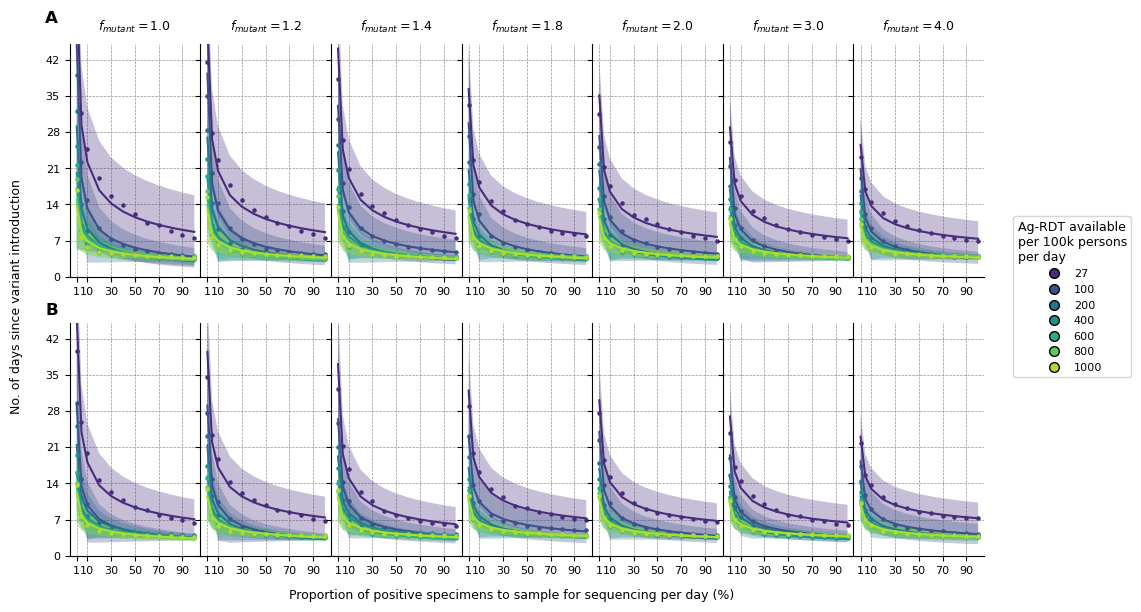

In [51]:
with plt.style.context('default'): 
    fig = plt.figure(figsize=(11.8, 8.3 * 0.8))
    gs = GridSpec(nrows=2, ncols=7, wspace=0.,)
    
    for i, ini_immune in enumerate(np.sort(results_df['ini_immune'].unique())):
        for f, f_mutant_beta in enumerate(np.sort(results_df['f_mutant_beta'].unique())): 
            f_results_df = results_df[(results_df['f_mutant_beta']==f_mutant_beta)&(results_df['ini_immune']==ini_immune)]
            seq_mode = 0
            ax = fig.add_subplot(gs[i, f])

            sm_f_results_df = f_results_df[f_results_df['seq_mode']==seq_mode].copy().set_index('n_test')
            for n, n_test in enumerate(test_N_arr):
                x_data = sm_f_results_df.loc[n_test, 'seq_prop'].to_numpy()
                y_data = sm_f_results_df.loc[n_test, 'expected_day_1'].to_numpy()
                y_sd_data = sm_f_results_df.loc[n_test, 'sd_expected_day'].to_numpy()
                
                """x_data = x_data[y_data>0]
                y_sd_data = y_sd_data[y_data>0]
                y_data = y_data[y_data>0]"""
                
                ax.scatter(x_data, y_data, color=test_cmap[n], marker='.', s=20, zorder=100)
                popt, pcov = curve_fit(linear_func, np.log(x_data), np.log(y_data)) # your data x, y to fit
                negpos_residuals = np.log(y_data) - linear_func(np.log(x_data), *popt)
                negpow_r2 = compute_r_squared(negpos_residuals, np.log(y_data))
                if negpow_r2 > 0.85: 
                    m, c = popt
                    ax.plot(x_data, np.exp(m * np.log(x_data) + c), color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                else: 
                    i, popt_1, popt_2 = two_phase_linear(x_data, y_data)
                    if i > 0: 
                        ax.plot(x_data[:i], popt_1[0] * x_data[:i] + popt_1[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                        ax.plot(x_data[i:], popt_2[0] * x_data[i:] + popt_2[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                    else: 
                        ax.plot(x_data, popt_1[0] * x_data + popt_1[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                
                y_sd_arr = []
                for yy in [y_data - y_sd_data, y_data + y_sd_data]:
                    popt, pcov = curve_fit(linear_func, np.log(x_data), np.log(yy)) # your data x, y to fit
                    negpos_residuals = np.log(yy) - linear_func(np.log(x_data), *popt)
                    negpow_r2 = compute_r_squared(negpos_residuals, np.log(yy))
                    
                    if negpow_r2 > 0.85: 
                        m, c = popt
                        y_sd_arr.append(np.exp(m * np.log(x_data) + c))
                    else: 
                        k, popt_1, popt_2 = two_phase_linear(x_data, yy)
                        if k > 0: 
                            y11 = popt_1[0] * x_data[:k] + popt_1[-1]
                            y22 = popt_2[0] * x_data[k:] + popt_2[-1]
                            y11[y11<min(y22)] = min(y22)
                            y_sd_arr.append(np.array(list(y11) + list(y22))) 
                        else: 
                            y_sd_arr.append(popt_1[0] * x_data + popt_1[-1])
                        
                yl = y_sd_arr[0]
                yu = y_sd_arr[1]
                ax.fill_between(x = x_data, y1 = yl, y2 = yu, 
                                interpolate=True, facecolor=test_cmap[n], edgecolor=None, zorder=50, alpha=0.3)

            ax.set_ylim(0., 45.)
            ax.set_yticks(np.arange(0, 45, 7))
            if f > 0: 
                ax.set_yticklabels([])
            ax.grid(axis='both', ls='--', lw=0.5, color='#929292', zorder=-100)
            ax.set_xticks([1] + list(np.arange(10, 110, 20)))
            ax.set_xlim(-5, 105)
            ax.tick_params(axis='both', labelsize=8)

            for axis in ['top', 'right']: 
                ax.spines[axis].set_visible(False)
                
            if i == 0:
                ax.set_title(r'$f_{mutant}=%.1f$'%(f_mutant_beta), fontsize=9, pad=10)
                
    fig.text(s='Proportion of positive specimens to sample for sequencing per day (%)', x=0.5, y=0.05, 
             ha='center', va='center', fontsize=9)
    fig.text(s='No. of days since variant introduction', x=0.08, y=0.5, 
             ha='center', va='center', fontsize=9, rotation=90)

    # legend 
    legend_handles = []
    for t, test_N in enumerate(test_N_arr): 
        legend_handles.append(Line2D([0], [0], marker='o', color='k', lw=0., label=test_N,
                              markerfacecolor=test_cmap[t], markersize=7))
    legend = fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(.92, 0.5), fontsize=8,
                        title="Ag-RDT available\nper 100k persons\nper day")
    legend.get_title().set_fontsize('9')
    
    fig.text(s=r"$\bf{A}$", x=0.11, y=.92, fontsize=12, ha='center', va='center')
    fig.text(s=r"$\bf{B}$", x=0.11, y=.48, fontsize=12, ha='center', va='center')
    
    plt.savefig('./gs_manuscript/figureS2.png', dpi=330, bbox_inches='tight')
    plt.show()

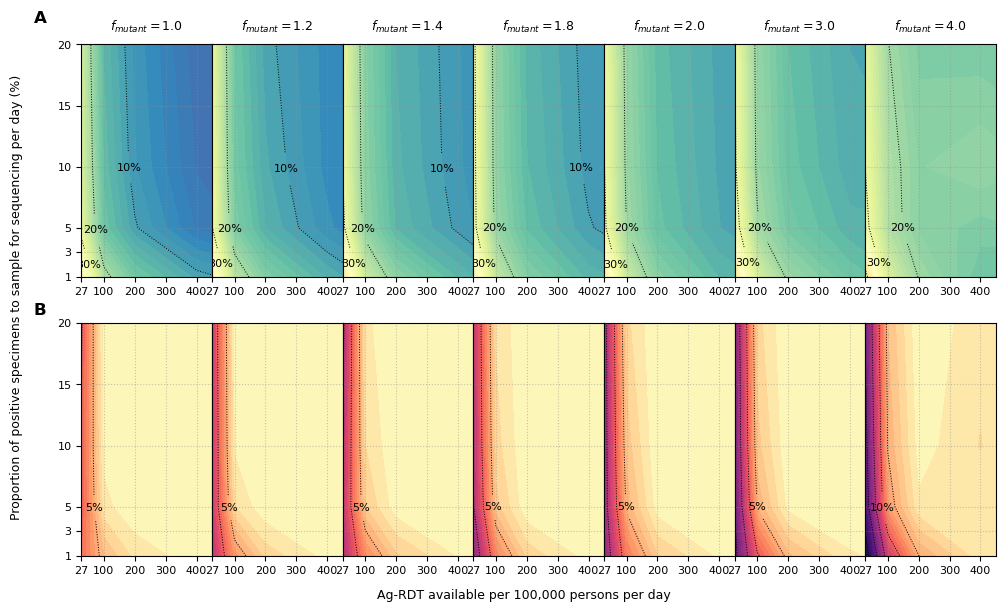

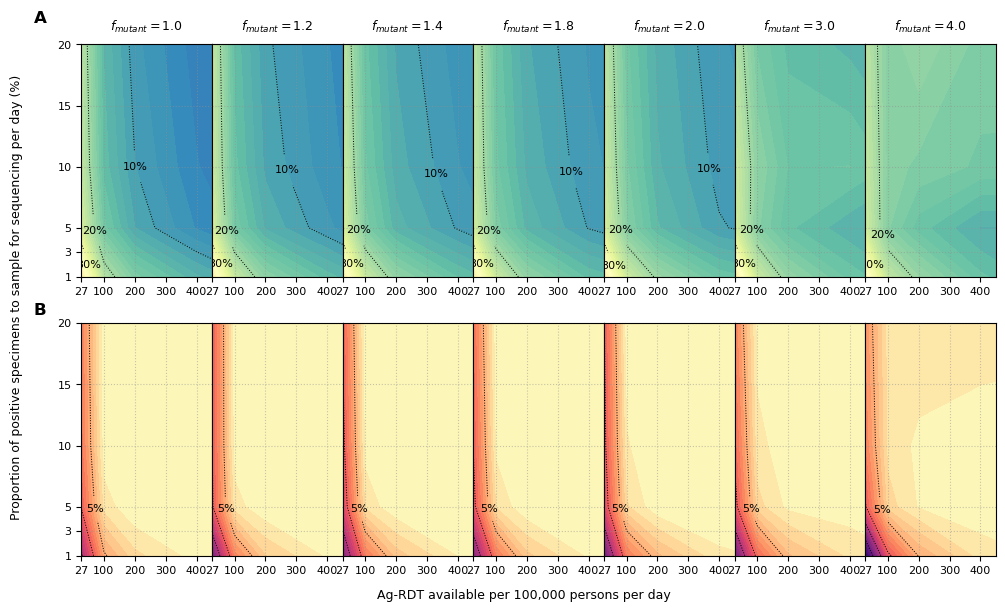

In [52]:
manual_locations = {('max_diff', 40, 1.0):[(50,2), (100,5), (200,10)], 
                    ('max_diff', 40, 1.2):[(50,2), (100,5), (300,10)], 
                    ('max_diff', 40, 1.4):[(50,2), (100,5), (400,10)], 
                    ('max_diff', 40, 1.8):[(50,2), (100,5), (400,10)], 
                    ('max_diff', 40, 2.0):[(70,2), (100,5), (400,10)], 
                    ('max_diff', 40, 3.0):[(50,2), (100,5),], 
                    ('max_diff', 40, 4.0):[(50,2), (150,5),], 
                    ('max_diff', 10, 1.0):[(50,2), (100,5), (200,10)], 
                    ('max_diff', 10, 1.2):[(50,2), (100,5), (300,10)], 
                    ('max_diff', 10, 1.4):[(50,2), (100,5), (400,10)], 
                    ('max_diff', 10, 1.8):[(50,2), (100,5), (400,10)], 
                    ('max_diff', 10, 2.0):[(70,2), (100,5),], 
                    ('max_diff', 10, 3.0):[(50,2), (100,5),], 
                    ('max_diff', 10, 4.0):[(50,2), (150,5),], 
                    ('prop_days_abv20_absdiff', 10, 1.0):[(100,5)], 
                    ('prop_days_abv20_absdiff', 10, 1.2):[(100,5)], 
                    ('prop_days_abv20_absdiff', 10, 1.4):[(100,5)], 
                    ('prop_days_abv20_absdiff', 10, 1.8):[(100,5)],                     
                    ('prop_days_abv20_absdiff', 10, 2.0):[(100,5)],                     
                    ('prop_days_abv20_absdiff', 10, 3.0):[(100,5)],                     
                    ('prop_days_abv20_absdiff', 10, 4.0):[(100,5)],
                    ('prop_days_abv20_absdiff', 40, 1.0):[(100,5)], 
                    ('prop_days_abv20_absdiff', 40, 1.2):[(100,5)], 
                    ('prop_days_abv20_absdiff', 40, 1.4):[(100,5)], 
                    ('prop_days_abv20_absdiff', 40, 1.8):[(100,5)],                     
                    ('prop_days_abv20_absdiff', 40, 2.0):[(100,5)],                     
                    ('prop_days_abv20_absdiff', 40, 3.0):[(100,5)],                     
                    ('prop_days_abv20_absdiff', 40, 4.0):[(100,5)],  
                    }

def plot_contour_plots(lidx, label, ini_immune):
    for f, f_mutant_beta in enumerate(np.sort(results_df['f_mutant_beta'].unique())): 
        f_results_df = results_df[(results_df['f_mutant_beta']==f_mutant_beta)&(results_df['ini_immune']==ini_immune)]
        seq_mode = 0
        ax = fig.add_subplot(gs[lidx, f])

        sm_f_results_df = f_results_df[f_results_df['seq_mode']==seq_mode].copy()#.set_index('n_test')
        #print (virus_results_df[label].min(), virus_results_df[label].max())

        fdf = sm_f_results_df[['n_test', 'seq_prop', label]]
        x = np.sort(fdf['n_test'].unique())
        y = np.sort(fdf['seq_prop'].unique())
        X, Y = np.meshgrid(x, y)
        Z = fdf.pivot('n_test', 'seq_prop').to_numpy()
        
        if label == 'max_diff':
            levels = np.linspace(0., 70, 71) 
            cf = ax.contourf(X, Y, Z.T, cmap='Spectral_r', levels=levels) ##, levels=np.linspace(0,0.5,51))
            levels = np.linspace(0., 60, 7) 
            cp = ax.contour(X, Y, Z.T, colors='k', linestyles='dotted', linewidths=0.7, levels=levels)
            
        else:
            levels = np.linspace(0., 30, 31) 
            cf = ax.contourf(X, Y, Z.T, cmap='magma_r', levels=levels) ##, levels=np.linspace(0,0.5,51))
            levels = np.linspace(5, 30, 6) 
            cp = ax.contour(X, Y, Z.T, colors='k', linestyles='dotted', linewidths=0.7, levels=levels)
            
        ax.set_ylim(1, 20)
        ax.set_yticks([1, 3] + list(np.arange(5,25,5)))
        if f > 0: 
            ax.set_yticklabels([])
            ax.tick_params(axis='y', left=False)
        ax.set_xlim(27, 450)
        ax.set_xticks([27, 100, 200, 300, 400])
        ax.grid(axis='both', ls='dotted', lw=0.8, c='#929292', alpha=0.5)

        ax.tick_params(axis='both', labelsize=8)
        
        try: 
            ct = ax.clabel(cp, colors='k', fontsize=8, inline=1, inline_spacing=4, fmt="%i%%", 
                           manual=manual_locations[(label, ini_immune, f_mutant_beta)],)
        except: 
            ct = ax.clabel(cp, colors='k', fontsize=8, inline=1, inline_spacing=4, fmt="%i%%")

        for l in ct:
            l.set_rotation(0)
            
        if lidx == 0: 
            ax.set_title(r'$f_{mutant}=%.1f$'%(f_mutant_beta), fontsize=9, pad=10)

for i, ini_immune in enumerate(np.sort(results_df['ini_immune'].unique())):
    with plt.style.context("default"): 
        fig = plt.figure(figsize=(11.8, 8.3 * 0.8))
        gs = GridSpec(nrows=2, ncols=7, wspace=0., hspace=0.2)
        
        for lidx, label in enumerate(['max_diff', 'prop_days_abv20_absdiff',]): # 'prop_days_w_mea'
            plot_contour_plots(lidx, label, ini_immune)
            
        fig.text(s='Ag-RDT available per 100,000 persons per day', x=0.5, y=0.05, fontsize=9, ha='center', va='center')
        fig.text(s='Proportion of positive specimens to sample for sequencing per day (%)', x=0.07, y=0.5, 
                 rotation=90, fontsize=9, ha='center', va='center')
        
        fig.text(s=r"$\bf{A}$", x=0.09, y=.92, fontsize=12, ha='center', va='center')
        fig.text(s=r"$\bf{B}$", x=0.09, y=.48, fontsize=12, ha='center', va='center')
        
        if ini_immune == 10: 
            plt.savefig('./gs_manuscript/figureS3.png', dpi=330, bbox_inches='tight')
        else: 
            plt.savefig('./gs_manuscript/figureS4.png', dpi=330, bbox_inches='tight')
            
        plt.show()

## Sensitivity analyses II - varying WT prevalence during variant introduction

In [53]:
seq_prop_arr = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  
test_N_arr = [27, 100, 200, 400, 600, 800, 1000]
f_mutant_beta_arr = [1., 3.]

# three modalities - (0) centralised, (1) all tert, (2) 1 tert, (3) 10% tert, (4) 25% tert, (5) 50% tert, 
seq_mode_arr = np.arange(6) 
seq_mode_cols = ['#7f3b08','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b']

prop_hospitalised_samples_diagnosed = 0.3 # proportion of hospitalised samples that are diagnosed
prop_hcfs_tertiary = 0.2 # proportion of all HCFs that are tertiary facilities 

seq_success_prob = 0.8

var_cols = ['#404040','#ca0020',]
var_type_arr = ['alpha', 'omicron']
test_N_cmap = sns.color_palette('Spectral', len(test_N_arr))

In [54]:
summary_df = []
summary_folder = './PATAT_gs_ms_data/20220307_surv_summary_10pc'
for fname in os.listdir(summary_folder): 
    # load and read json 
    with gzip.open("%s/%s"%(summary_folder, fname), "r") as f:
        data = f.read()
        row = json.loads(data.decode('utf-8'))
    if row['init_wt_prop'] > 0.1: 
        continue 
    summary_df.append(row)
    
summary_folder = './PATAT_gs_ms_data/20220201_surv_summary'
for fname in os.listdir(summary_folder): 
    # load and read json 
    with gzip.open("%s/%s"%(summary_folder, fname), "r") as f:
        data = f.read()
        row = json.loads(data.decode('utf-8'))
    if row['f_mutant_beta'] != 3: 
        continue 
    row['init_wt_prop'] = 0.01
    summary_df.append(row)
        
summary_df = pd.DataFrame.from_dict(summary_df)
summary_df.head()

,init_mt_prop,init_wt_prop,init_immune_prop,f_mutant_beta,number_of_rdt_per_100k_per_day,nc_demand,fpath,set_id,run_id,weekdays_arr,...,wt_infectious_arr,mt_infectious_arr,diagnosed_var_arr,diagnosed_agents_arr,diagnosed_day_arr,diagnosed_hcf_arr,all_hcf_n,falpos_agents_arr,falpos_day_arr,falpos_hcf_arr
0,0.0001,0.10,0.1,3.0,800,1,./20220307_surv_sens10pc/surv10pc_baseline_set021,21,3,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...",...,"[75472.0, 75586.0, 82205.0, 98027.0, 85847.0, ...","[0.0, 1.0, 11.0, 45.0, 74.0, 91.0, 110.0, 132....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[41, 100, 104, 124, 153, 170, 204, 207, 256, 2...","[10, 31, 1, 10, 10, 24, 24, 4, 0, 10, 24, 31, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[5474, 8521, 30899, 40076, 49607, 51109, 80360...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 4, 5, 7, 7, 11, 11, 13, 16, 16, 17, 17,..."
1,0.0001,0.05,0.1,3.0,1000,1,./20220307_surv_sens10pc/surv10pc_baseline_set024,24,1,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...",...,"[49279.0, 49326.0, 52055.0, 61089.0, 56079.0, ...","[0.0, 0.0, 13.0, 38.0, 67.0, 89.0, 120.0, 158....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[36, 100, 143, 180, 190, 205, 227, 233, 244, 2...","[10, 10, 5, 17, 11, 10, 4, 17, 10, 1, 5, 17, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[20612, 27520, 28567, 34788, 77223, 114824, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3, 4, 5, 11, 16, 18, 20, 20, 23, 24, 25, 2..."
2,0.0001,0.10,0.1,3.0,27,1,./20220307_surv_sens10pc/surv10pc_baseline_set001,1,7,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...",...,"[61763.0, 61885.0, 68150.0, 90887.0, 96898.0, ...","[0.0, 0.0, 9.0, 38.0, 73.0, 92.0, 105.0, 140.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[291, 537, 1129, 1175, 1604, 1730, 2237, 2314,...","[31, 24, 3, 17, 17, 17, 17, 24, 31, 10, 3, 31,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[21580, 223426, 240098, 249610, 312958, 509871...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, ...","[3, 31, 34, 35, 44, 72, 77, 84, 109, 131, 3, 1..."
3,0.0001,0.05,0.1,3.0,100,1,./20220307_surv_sens10pc/surv10pc_baseline_set004,4,5,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...",...,"[46352.0, 46408.0, 49194.0, 58729.0, 55204.0, ...","[0.0, 0.0, 10.0, 43.0, 77.0, 94.0, 109.0, 154....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 543, 593, 716, 873, 1004, 1382, 1563, 2418...","[10, 10, 17, 10, 10, 24, 17, 24, 10, 24, 17, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[13444, 15106, 50141, 137049, 210198, 219326, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 7, 19, 29, 31, 33, 37, 41, 53, 74, 76, ..."
4,0.0001,0.05,0.1,3.0,200,1,./20220307_surv_sens10pc/surv10pc_baseline_set008,8,6,"[4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, ...",...,"[45048.0, 45086.0, 48338.0, 56466.0, 49787.0, ...","[0.0, 0.0, 12.0, 45.0, 80.0, 105.0, 118.0, 153...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[63, 143, 154, 156, 218, 278, 297, 314, 384, 4...","[24, 3, 4, 10, 17, 0, 10, 24, 0, 10, 17, 17, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",143,"[15111, 35912, 38078, 39460, 94001, 146238, 16...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 5, 5, 5, 13, 21, 23, 23, 25, 29, 31, 32, 3..."


In [55]:
results_df = []
delay = 7

for wti, init_wt_prop in enumerate(np.sort(summary_df['init_wt_prop'].unique())): 
    var_summary_df = summary_df[summary_df['init_wt_prop']==init_wt_prop].copy()
    
    for set_id in np.sort(var_summary_df['set_id'].unique()): 
        ntest_var_summary_df = var_summary_df[var_summary_df['set_id']==set_id]
        n_test = ntest_var_summary_df['number_of_rdt_per_100k_per_day'].unique()[0]
        f_mutant_beta = ntest_var_summary_df['f_mutant_beta'].unique()[0]

        for seq_prop in seq_prop_arr: 
            first_dection_arr = np.zeros((1000, 8), dtype=float)
            max_abs_diff_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode  
            gmean_abs_diff_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode           
            prop_days_abs_diff_abv20_arr = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode
            prop_days_w_measurement = np.zeros((1000, 8), dtype=float) # sim_i x seq_mode
            
            for run_id in np.arange(10): 
                # get true rel proportions                 
                set_run_row = ntest_var_summary_df[ntest_var_summary_df['run_id']==run_id]
                wt_infectious_arr = np.array(set_run_row['wt_infectious_arr'].iloc[0])/1e6
                mt_infectious_arr = np.array(set_run_row['mt_infectious_arr'].iloc[0])/1e6
                rel_mt_inf_prop_arr = mt_infectious_arr/(wt_infectious_arr + mt_infectious_arr)
                
                # get simulation results 
                if init_wt_prop > 0.01:
                    fname = "./PATAT_gs_ms_data/sens_10pc/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop)
                else: 
                    fname = "./PATAT_gs_ms_data/20220208_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop)
                
                try: 
                    result_arr = np.load(fname)
                except: 
                    continue 
                var_seq_arr = result_arr['var_seq_arr']
                
                # for each simulation 
                for idx in np.arange(100):
                    sim_i = run_id * 100 + idx
                    # find first detection day 
                    curr_day_arr, curr_seq_mode_arr = np.where(var_seq_arr[idx,:,:,1] > 0)
                    first_dection_arr[sim_i] = [curr_day_arr[curr_seq_mode_arr==seq_mode].min() if len(curr_day_arr[curr_seq_mode_arr==seq_mode]) > 0 else 91 for seq_mode in np.arange(8)]
                    # get largest difference in measured and true variant proportion 
                    for seq_mode in np.arange(8): 
                        if seq_mode == 1 or seq_mode == 3: 
                            continue 
                        sim_seq_arr = var_seq_arr[idx,:,seq_mode,:]

                        sim_seq_day_range = np.arange(delay, 91, delay)
                        sim_seq_n_arr = np.array([sim_seq_arr[day-delay:day,:].sum() for day in sim_seq_day_range])
                        sim_seq_mask = sim_seq_n_arr > 0
                        sim_seq_day_range = sim_seq_day_range[sim_seq_mask]
                        
                        # get maximum error between measured and circulating variant proportion
                        mean_rel_mt_prop = np.array([rel_mt_inf_prop_arr[day-delay:day].mean() for day in sim_seq_day_range])
                        mean_rel_mt_seq = np.array([sim_seq_arr[day-delay:day,1].sum()/sim_seq_arr[day-delay:day,:].sum() for day in sim_seq_day_range])
                        
                        mean_abs_err = np.abs(mean_rel_mt_seq-mean_rel_mt_prop)
                        gmean_abs_diff_arr[sim_i, seq_mode] = np.prod(mean_abs_err)**(1/len(mean_abs_err))
                        max_abs_diff_arr[sim_i, seq_mode] = np.max(mean_abs_err)
                        
                        prop_days_w_measurement[sim_i, seq_mode] = len(mean_abs_err)/90
                        prop_days_abs_diff_abv20_arr[sim_i, seq_mode] = len(mean_abs_err[mean_abs_err>0.2])/len(mean_abs_err)
                        
            for seq_mode, idx in enumerate([0, 4, 5, 6, 7, 2]):
                sm_first_dection_arr = first_dection_arr[:,idx]
                prop_not_detected = len(sm_first_dection_arr[sm_first_dection_arr>=91])/len(sm_first_dection_arr)
                
                # get day under which variant will be detected with 95% confidence 
                detected_sm_first_dection_arr = sm_first_dection_arr[sm_first_dection_arr<91]
                sm_first_detection_prob = np.array([len(detected_sm_first_dection_arr[detected_sm_first_dection_arr<=day])/len(sm_first_dection_arr) for day in np.sort(np.unique(sm_first_dection_arr))])
                
                prob95_day = np.where(sm_first_detection_prob>=0.95)[0][0]
                expected_day = np.mean(sm_first_dection_arr)
                sd_expected_day = np.std(sm_first_dection_arr, ddof=1)
                
                results_df.append({'init_wt_prop':init_wt_prop, 'f_mutant_beta':f_mutant_beta, 
                                   'n_test':n_test, 'seq_prop':seq_prop, 'seq_mode':seq_mode, 
                                   'prob_not_detected':prop_not_detected * 100,
                                   'expected_day_1':expected_day, 'sd_expected_day':sd_expected_day, 'prob95_day_1':prob95_day, 
                                   'max_diff':max_abs_diff_arr[:,idx].mean() * 100, 
                                   'gmean_err':gmean_abs_diff_arr[:,idx].mean() * 100,
                                   'prop_days_w_mea':prop_days_w_measurement[:,idx].mean() * 100, 
                                   'prop_days_abv20_absdiff':prop_days_abs_diff_abv20_arr[:,idx].mean() * 100})

results_df = pd.DataFrame.from_dict(results_df)
results_df.head()

,init_wt_prop,f_mutant_beta,n_test,seq_prop,seq_mode,prob_not_detected,expected_day_1,sd_expected_day,prob95_day_1,max_diff,gmean_err,prop_days_w_mea,prop_days_abv20_absdiff
0,0.01,3.0,27,1,0,0.0,26.086,5.912492,22,40.767458,6.525655,11.887778,21.969293
1,0.01,3.0,27,1,1,0.0,28.901,5.925395,24,45.569879,7.750272,9.987778,24.306894
2,0.01,3.0,27,1,2,0.0,26.369,5.647365,21,41.369680,6.687414,11.562222,22.034520
3,0.01,3.0,27,1,3,0.0,25.853,5.751040,20,40.776850,6.598905,11.793333,21.688939
4,0.01,3.0,27,1,4,0.0,25.903,5.600621,21,40.164901,6.575097,11.795556,21.221818


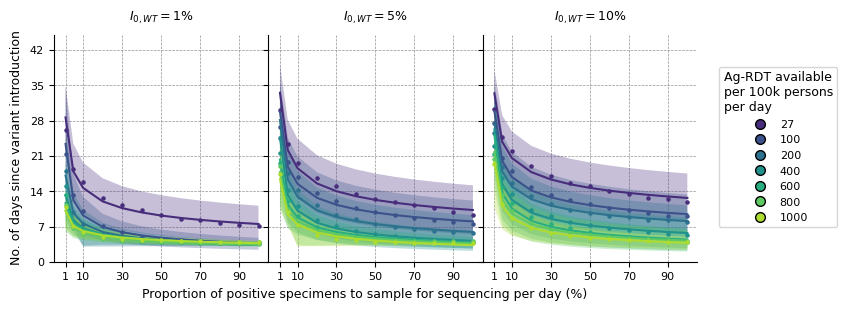

In [61]:
seq_mode_labels = ['Population-wide', r"$\bf{ONE}$" + " tertiary facility", "10%", "25%", "50%", "100%"]

def linear_func(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def compute_r_squared(residuals, y): 
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res / ss_tot)

def two_phase_linear(x, y):
    
    i_to_r2 = {}
    i_to_popt = {}
    
    for i in np.arange(3, len(x)-2): 
        if x[i] > 20: 
            break
        
        popt_1, pcov_1 = curve_fit(linear_func, x[:i], y[:i]) # your data x, y to fit
        popt_2, pcov_2 = curve_fit(linear_func, x[i:], y[i:]) # your data x, y to fit
        y_pred = list(linear_func(x[:i], *popt_1)) + list(linear_func(x[i:], *popt_2))
        residuals = y - y_pred
        r2 = compute_r_squared(residuals, y)
        if r2 > 0.8:
            i_to_r2[i] = r2
            i_to_popt[i] = (i, popt_1, popt_2)
    
    if len(i_to_popt) > 0: 
        return i_to_popt[max(i_to_r2, key=i_to_r2.get)]
    else: 
        popt_1, pcov_1 = curve_fit(linear_func, x, y)
        return 0, popt_1, None

test_cmap = sns.color_palette('viridis', len(test_N_arr))

with plt.style.context('default'): 
    fig = plt.figure(figsize=(8.3, 11.8 * 0.25))
    gs = GridSpec(nrows=1, ncols=3, wspace=0.,)
    
    for i, init_wt_prop in enumerate(np.sort(results_df['init_wt_prop'].unique())):
        
        f_results_df = results_df[(results_df['init_wt_prop']==init_wt_prop)]
        seq_mode = 0
        ax = fig.add_subplot(gs[i])

        sm_f_results_df = f_results_df[f_results_df['seq_mode']==seq_mode].copy().set_index('n_test')
        for n, n_test in enumerate(test_N_arr):
            x_data = sm_f_results_df.loc[n_test, 'seq_prop'].to_numpy()
            y_data = sm_f_results_df.loc[n_test, 'expected_day_1'].to_numpy()
            y_sd_data = sm_f_results_df.loc[n_test, 'sd_expected_day'].to_numpy()
            ax.scatter(x_data, y_data, color=test_cmap[n], marker='.', s=20, zorder=100)

            popt, pcov = curve_fit(linear_func, np.log(x_data), np.log(y_data)) # your data x, y to fit
            negpos_residuals = np.log(y_data) - linear_func(np.log(x_data), *popt)
            negpow_r2 = compute_r_squared(negpos_residuals, np.log(y_data))
            if negpow_r2 > 0.85: 
                m, c = popt
                ax.plot(x_data, np.exp(m * np.log(x_data) + c), color=test_cmap[n], ls='-', lw=1.5, zorder=100)
            else: 
                i, popt_1, popt_2 = two_phase_linear(x_data, y_data)
                if i > 0: 
                    ax.plot(x_data[:i], popt_1[0] * x_data[:i] + popt_1[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                    ax.plot(x_data[i:], popt_2[0] * x_data[i:] + popt_2[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
                else: 
                    ax.plot(x_data, popt_1[0] * x_data + popt_1[-1], color=test_cmap[n], ls='-', lw=1.5, zorder=100)
            
            y_sd_arr = []
            for yy in [y_data - y_sd_data, y_data + y_sd_data]:
                popt, pcov = curve_fit(linear_func, np.log(x_data), np.log(yy)) # your data x, y to fit
                negpos_residuals = np.log(yy) - linear_func(np.log(x_data), *popt)
                negpow_r2 = compute_r_squared(negpos_residuals, np.log(yy))
                if negpow_r2 > 0.85: 
                    m, c = popt
                    y_sd_arr.append(np.exp(m * np.log(x_data) + c))
                else: 
                    k, popt_1, popt_2 = two_phase_linear(x_data, yy)
                    if k > 0: 
                        y11 = popt_1[0] * x_data[:k] + popt_1[-1]
                        y22 = popt_2[0] * x_data[k:] + popt_2[-1]
                        y11[y11<min(y22)] = min(y22)
                        y_sd_arr.append(np.array(list(y11) + list(y22))) 
                    else: 
                        y_sd_arr.append(popt_1[0] * x_data + popt_1[-1])
            ax.fill_between(x = x_data, y1 = y_sd_arr[0], y2 = y_sd_arr[1], 
                            interpolate=True, facecolor=test_cmap[n], edgecolor=None, zorder=50, alpha=0.3)

        ax.set_ylim(0., 45.)
        ax.set_yticks(np.arange(0, 45, 7))
        if i > 0: 
            ax.set_yticklabels([])
        ax.grid(axis='both', ls='--', lw=0.5, color='#929292', zorder=-100)
        ax.set_xticks([1] + list(np.arange(10, 110, 20)))
        ax.set_xlim(-5, 105)
        ax.tick_params(axis='both', labelsize=8)

        for axis in ['top', 'right']: 
            ax.spines[axis].set_visible(False)

        #if i == 0:
        ax.set_title(r'$I_{0,WT}=%i$%%'%(init_wt_prop * 100), fontsize=9, pad=10)
                
    fig.text(s='Proportion of positive specimens to sample for sequencing per day (%)', x=0.5, y=0., 
             ha='center', va='center', fontsize=9)
    fig.text(s='No. of days since variant introduction', x=0.08, y=0.5, 
             ha='center', va='center', fontsize=9, rotation=90)

    # legend 
    legend_handles = []
    for t, test_N in enumerate(test_N_arr): 
        legend_handles.append(Line2D([0], [0], marker='o', color='k', lw=0., label=test_N,
                              markerfacecolor=test_cmap[t], markersize=7))
    legend = fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(.92, 0.5), fontsize=8,
                        title="Ag-RDT available\nper 100k persons\nper day")
    legend.get_title().set_fontsize('9')
    
    plt.savefig('./gs_manuscript/figure5.png', dpi=330, bbox_inches='tight')
    #plt.savefig('./gs_manuscript/figure5.pdf', bbox_inches='tight')
    plt.show()

In [62]:
def logistic_growth_func(t, r):
    a = (1/0.0001) - 1
    return 1 / (1 + a * np.exp(-r * t))

try: 
    all_per_day_specimens_arr = np.load("./PATAT_gs_ms_data/sens10pc_all_per_day_specimens_arr.npz")['all_per_day_specimens_arr']
except:
    # init_wt_prop x len(test_N_arr) x sim_i x days x len(seq_mode_arr) x (WT, MT, FP)
    all_per_day_specimens_arr = np.zeros((3, len(test_N_arr), 1000, 91, len(seq_mode_arr), 3), dtype=float)
    
    
    for v, init_wt_prop in enumerate(np.sort(summary_df['init_wt_prop'].unique())):
        var_summary_df = summary_df[summary_df['init_wt_prop']==init_wt_prop]
        fbeta_var_summary_df = var_summary_df

        """var_growth_rate = []"""
        for j, n_test in enumerate(test_N_arr): 
            ntest_fbeta_var_summary_df = fbeta_var_summary_df[fbeta_var_summary_df['number_of_rdt_per_100k_per_day']==n_test].copy().set_index("run_id")

            sim_N = 100 # no. of GS simulations to run for each run 
            for run_id in ntest_fbeta_var_summary_df.index: 
                wt_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'wt_infectious_arr'])
                mt_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'mt_infectious_arr'])

                """
                # fit true var prop arr to logistic growth for wohl et al's model 
                x = np.arange(91)
                popt, pcov = curve_fit(logistic_growth_func, x, true_var_prop_arr)
                var_growth_rate.append(popt[0])
                """

                # get diagnosed, falpos and hospitalised agents' info 
                diagnosed_var_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_var_arr'])
                diagnosed_agents_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_agents_arr'])
                diagnosed_day_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_day_arr'])
                diagnosed_hcf_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'diagnosed_hcf_arr'])

                falpos_agents_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'falpos_agents_arr'])
                falpos_day_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'falpos_day_arr'])
                falpos_hcf_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'falpos_hcf_arr'])

                hospitalised_var_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_var_arr'])
                hospitalised_agents_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_agents_arr'])
                hospitalised_day_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_day_arr'])
                hospitalised_hcf_arr = np.array(ntest_fbeta_var_summary_df.loc[run_id, 'hospitalised_hcf_arr'])

                tert_hcf_n = np.around(ntest_fbeta_var_summary_df.loc[run_id, 'all_hcf_n'] * prop_hcfs_tertiary).astype(np.int32)

                for i in np.arange(sim_N): 
                    sim_i = (run_id * sim_N) + i
                    # randomly select HCFs as tertiary facilities 
                    tert_hcf_arr = np.random.choice(np.arange(ntest_fbeta_var_summary_df.loc[run_id, 'all_hcf_n']), tert_hcf_n, replace=False)

                    i_to_selected_tert_hcfs = {}
                    for i, tert_hcf_f in enumerate([0, 0.1, 0.25, 0.5]):
                        if tert_hcf_f == 0:
                            selected_tert_hcf = np.array([np.random.choice(tert_hcf_arr)])
                        else:
                            selected_tert_hcf = np.random.choice(tert_hcf_arr, np.around(tert_hcf_f * tert_hcf_n).astype(np.int32), replace=False)
                        i_to_selected_tert_hcfs[2+i] = selected_tert_hcf

                    for day in np.arange(91): 
                        # day mask 
                        diagnosed_day_mask = diagnosed_day_arr == day 
                        falpos_day_mask = falpos_day_arr == day
                        hospitalised_day_mask = hospitalised_day_arr == day
                        # hcf mask 
                        diagnosed_hcf_mask = np.isin(diagnosed_hcf_arr, tert_hcf_arr)
                        falpos_hcf_mask = np.isin(falpos_hcf_arr, tert_hcf_arr)
                        hospitalised_hcf_mask = np.isin(hospitalised_hcf_arr, tert_hcf_arr) 

                        for seq_mode in seq_mode_arr: 
                            if seq_mode == 0: 
                                # seq_mode 0: centralised 
                                pos_specimens = np.array(list(diagnosed_var_arr[diagnosed_day_mask]) + [-1] * len(falpos_agents_arr[falpos_day_mask])+ list(hospitalised_var_arr[hospitalised_day_mask]))
                            elif seq_mode == 1:
                                # seq_mode 1: tert facilities only 
                                pos_specimens = np.array(list(diagnosed_var_arr[diagnosed_hcf_mask&diagnosed_day_mask]) + [-1] * len(falpos_agents_arr[falpos_hcf_mask&falpos_day_mask]) + list(hospitalised_var_arr[hospitalised_hcf_mask&hospitalised_day_mask]))
                            else: 
                                # hcf mask 
                                diagnosed_hcf_mask = np.isin(diagnosed_hcf_arr, i_to_selected_tert_hcfs[seq_mode])
                                falpos_hcf_mask = np.isin(falpos_hcf_arr, i_to_selected_tert_hcfs[seq_mode])
                                hospitalised_hcf_mask = np.isin(hospitalised_hcf_arr, i_to_selected_tert_hcfs[seq_mode])
                                pos_specimens = np.array(list(diagnosed_var_arr[diagnosed_hcf_mask&diagnosed_day_mask]) + [-1] * len(falpos_agents_arr[falpos_hcf_mask&falpos_day_mask]) + list(hospitalised_var_arr[hospitalised_hcf_mask&hospitalised_day_mask]))    

                            all_per_day_specimens_arr[v, j, sim_i, day, seq_mode, :] = [len(pos_specimens[pos_specimens==vtype]) for vtype in np.arange(-1, 2)]

    # save arrays 
    np.savez("./PATAT_gs_ms_data/sens10pc_all_per_day_specimens_arr.npz", all_per_day_specimens_arr=all_per_day_specimens_arr)                        

In [63]:
weekday_arr = []
curr_day = 4 
for day in np.arange(91): 
    if curr_day == 7: 
        curr_day = 0
    weekday_arr.append(curr_day)
    curr_day += 1
weekday_arr = np.array(weekday_arr)
time_period_arr = np.arange(91)
seq_day_arr = time_period_arr[weekday_arr==0]

try: 
    prev_recc_specimens_tot_per_week = np.load('./PATAT_gs_ms_data/sens10pc_prev_recc_specimens_tot_per_week.npz')['prev_recc_specimens_tot_per_week']
except:
    # simulate for each reccomendation 
    prev_recc_specimens_tot_per_week = np.zeros((3, len(test_N_arr), 1000, len(seq_mode_arr), len(seq_day_arr)), dtype=np.int32)

    for v, init_wt_prop in enumerate(np.sort(summary_df['init_wt_prop'].unique())):
        for j, n_test in enumerate(test_N_arr): 
            for sim_i in np.arange(1000): 
                for seq_mode in seq_mode_arr: # for each seq mode 
                    per_day_specimens_arr = all_per_day_specimens_arr[v,j,sim_i,:,seq_mode,:]

                    # perform week by week sampling 
                    for d, day in enumerate(seq_day_arr): 
                        if d == 0:
                            curr_days_to_sample = np.arange(0, day)
                        else: 
                            curr_days_to_sample = np.arange(seq_day_arr[d-1], day)

                        curr_week_specimens = per_day_specimens_arr[curr_days_to_sample,:].sum(axis=0)
                        tot_specimens_n = curr_week_specimens.sum()
                        prev_recc_specimens_tot_per_week[v,j,sim_i,seq_mode,d] = tot_specimens_n

    np.savez('./PATAT_gs_ms_data/sens10pc_prev_recc_specimens_tot_per_week.npz', prev_recc_specimens_tot_per_week=prev_recc_specimens_tot_per_week)                                

In [64]:
delay_arr = [0, 3, 7, 14, 21]
delay_cmap = sns.color_palette('YlOrRd', len(delay_arr))

sm_to_idx = {seq_mode:idx for seq_mode, idx in enumerate([0, 4, 5, 6, 7, 2])}

actual_detect_day1 = {}
tot_spec_dict = {}

for init_wt_prop in np.sort(summary_df['init_wt_prop'].unique()): 

    var_summary_df = summary_df[(summary_df['init_wt_prop']==init_wt_prop)].copy()
    
    for set_id in np.sort(var_summary_df['set_id'].unique()): 
        ntest_var_summary_df = var_summary_df[var_summary_df['set_id']==set_id]
        n_test = ntest_var_summary_df['number_of_rdt_per_100k_per_day'].unique()[0]
        
        for seq_prop in seq_prop_arr: 
            
            first_dection_arr = np.zeros((1000, 6, len(delay_arr)), dtype=float)
            mean_seq_per_week_arr = np.zeros((1000, 6, len(delay_arr)), dtype=float)
            
            for run_id in np.arange(10): 
                # get true rel proportions                 
                set_run_row = ntest_var_summary_df[ntest_var_summary_df['run_id']==run_id]
                wt_infectious_arr = np.array(set_run_row['wt_infectious_arr'].iloc[0])/1e6
                mt_infectious_arr = np.array(set_run_row['mt_infectious_arr'].iloc[0])/1e6
                rel_mt_inf_prop_arr = mt_infectious_arr/(wt_infectious_arr + mt_infectious_arr)
                
                # get simulation results 
                if init_wt_prop > 0.01: 
                    result_arr = np.load("./PATAT_gs_ms_data/sens_10pc/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop))
                else: 
                    result_arr = np.load("./PATAT_gs_ms_data/20220208_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop))
                    #print ("./20220208_gs_sim/set%03i_run%03i_seq%03i_sim_arr.npz"%(set_id, run_id, seq_prop))
                var_seq_arr = result_arr['var_seq_arr']
                
                # for each simulation 
                for idx in np.arange(100):
                    sim_i = run_id * 100 + idx
                    
                    for seq_mode in np.arange(6):
                        curr_var_seq_arr = var_seq_arr[idx,:,sm_to_idx[seq_mode],:]
                        
                        found_day_1 = 0
                        n_seq_per_week = []
                        for d, day in enumerate(seq_day_arr): 
                            if d > 0: 
                                week_arr = np.arange(seq_day_arr[d-1], day)
                            else: 
                                week_arr = np.arange(0, day)
                            
                            week_var_seq_arr = curr_var_seq_arr[week_arr,:]
                            if (found_day_1 == 0) and (week_var_seq_arr[:,1].sum() > 0): 
                                first_dection_arr[sim_i,seq_mode,:] = day + delay_arr
                                found_day_1 = 1
                            
                            if len(week_arr) == 7: 
                                n_seq_per_week.append(week_var_seq_arr.sum())
                        mean_seq_per_week_arr[sim_i,seq_mode,:] = np.mean(n_seq_per_week)
            
            expected_first_detection = first_dection_arr.mean(axis=0)
            sd_expected_day = first_dection_arr.std(axis=0, ddof=1)
            prob95_first_detection = np.zeros(expected_first_detection.shape, dtype=float)
            
            mean_seq_per_week = mean_seq_per_week_arr.mean(axis=0)
            
            for seq_mode in np.arange(6): 
                for d, delay in enumerate(delay_arr): 
                    sm_delay_first_detect_arr = first_dection_arr[:,seq_mode,d]
                    sm_delay_first_detect_prob = np.array([len(sm_delay_first_detect_arr[sm_delay_first_detect_arr<=day])/len(sm_delay_first_detect_arr) for day in np.sort(np.unique(sm_delay_first_detect_arr))])
                    prob95_first_detection[seq_mode, d] = np.sort(np.unique(sm_delay_first_detect_arr))[sm_delay_first_detect_prob>=0.95][0]
            
            try: 
                actual_detect_day1[init_wt_prop][n_test][seq_prop] = {'expected':expected_first_detection, 'sd':sd_expected_day, 'prob95':prob95_first_detection, 'mean_seq_per_week':mean_seq_per_week}
            except: 
                try: 
                    actual_detect_day1[init_wt_prop][n_test] = {seq_prop:{'expected':expected_first_detection, 'sd':sd_expected_day, 'prob95':prob95_first_detection, 'mean_seq_per_week':mean_seq_per_week}}
                except: 
                    actual_detect_day1[init_wt_prop] = {n_test:{seq_prop:{'expected':expected_first_detection, 'sd':sd_expected_day, 'prob95':prob95_first_detection, 'mean_seq_per_week':mean_seq_per_week}}}

[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] [  1  10  20  30  40  50  60  70  80  90 100]
[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] [  1  10  20  30  40  50  60  70  80  90 100]
[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] [  1  10  20  30  40  50  60  70  80  90 100]
[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] [ 1  5 10 20 30]


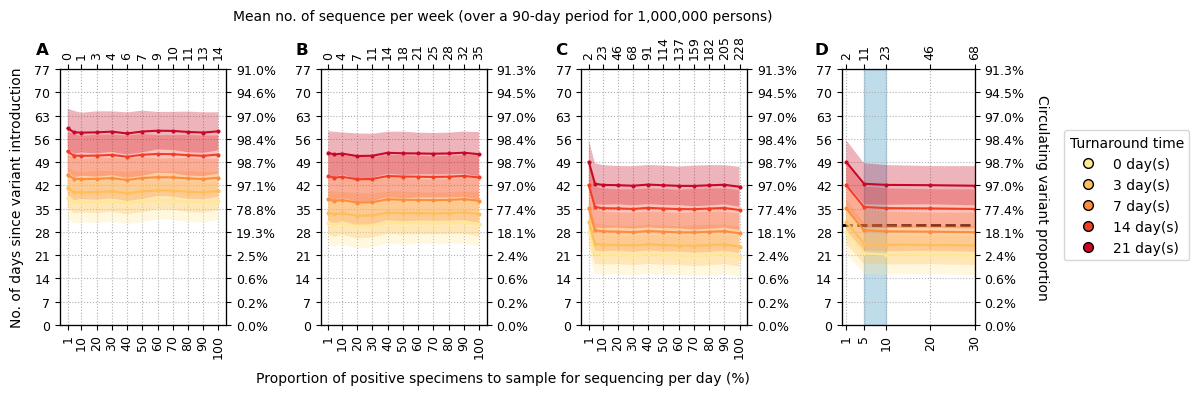

In [65]:
def linear_func(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B
    
sm_to_idx = {seq_mode:idx for seq_mode, idx in enumerate([0, 2, 3, 4, 5, 1])}

def plot_ax(ax, n_test = 200, seq_mode = 3, init_wt_prop = 0.1 , ax_id=0): 
    
    n = test_N_arr.index(n_test)
    fdf_summary = summary_df[(summary_df['number_of_rdt_per_100k_per_day']==n_test)&(summary_df['init_wt_prop']==init_wt_prop)].copy()
    all_mt_arr = np.zeros((10, 91), dtype=float)
    for r, row in fdf_summary.iterrows(): 
        mt_arr = np.array(row['mt_infectious_arr'])  #np.array(row['mt_exp_arr']) + np.array(row['mt_exp_arr'])
        wt_arr = np.array(row['wt_infectious_arr'])  #np.array(row['wt_exp_arr']) + np.array(row['wt_exp_arr'])
        all_mt_arr[row['run_id']] = mt_arr/(mt_arr+wt_arr)
    mean_mt_arr = all_mt_arr.mean(axis=0)

    for d, delay in enumerate(delay_arr): 

        x = np.sort(list(actual_detect_day1[init_wt_prop][n_test].keys()))
        y = np.array([actual_detect_day1[init_wt_prop][n_test][seq_prop]['expected'][seq_mode,d] for seq_prop in x])
        y_sd = np.array([actual_detect_day1[init_wt_prop][n_test][seq_prop]['sd'][seq_mode,d] for seq_prop in x])        
        y_low = y - y_sd
        y_high = y + y_sd
        
        y = np.log(y)
        x = np.log(x)
        # fit line 
        popt, pcov = curve_fit(linear_func, x, y) # your data x, y to fit
        m, c = popt

        ax.scatter(np.exp(x), np.exp(y), color=delay_cmap[d], zorder=100, marker='.', s=15)
        ax.plot(np.exp(x), np.exp(y), color=delay_cmap[d], lw=1.5, zorder=100,)# marker='.', s=15)
        #ax.plot(np.exp(x), np.exp(m * x + c), color=delay_cmap[d], zorder=100, lw = 1.5)        
        ax.fill_between(x = np.exp(x), y1 = y_low, y2 = y_high, 
                        interpolate=True, facecolor=delay_cmap[d], edgecolor=None, zorder=50, alpha=0.3)

    ax.set_yticks(np.arange(0, 77+7, 7))
    ax.set_ylim(0., 77)
    if ax_id == 3: 
        ax.set_xticks([1, 5, 10, 20, 30])
        ax.set_xlim(0, 30)
    else: 
        ax.set_xticks([1] + list(np.arange(10, 110, 10)))
        ax.set_xlim(-4, 105)
    ax.grid(axis='both', ls='dotted', lw=0.8, zorder=-100)
    ax.tick_params(axis='both', labelsize=9)
    ax.tick_params(axis='x', rotation=90)

    ax2 = ax.twinx()
    ax2.set_yticks(np.arange(0, 77+7, 7))
    ax2.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1])
    ax2.set_yticklabels(["%.1f%%"%(f*100) for f in mean_mt_arr[np.arange(0, 77+7, 7)]])
    ax2.tick_params(axis='both', labelsize=9)
    
    if init_wt_prop == 0.01: 
        v = 0 
    elif init_wt_prop == 0.05: 
        v = 1 
    else: 
        v = 2 
    tot_recc_specimens = prev_recc_specimens_tot_per_week[v,n,:,sm_to_idx[seq_mode],:]
    y_seq = []
    for seq_prop in seq_prop_arr: 
        y_seq.append((seq_prop/100 * tot_recc_specimens[tot_recc_specimens>0]).mean())
    y_seq = np.array(y_seq)

    ax3 = ax.twiny()
    ax3.set_xticks(ax.get_xticks())
    print (seq_prop_arr, ax.get_xticks())
    ax3.set_xticklabels(np.around(y_seq[np.isin(seq_prop_arr, ax.get_xticks())], 0).astype(np.int32), rotation=90)
    ax3.set_xlim(ax.get_xlim()[0], ax.get_xlim()[-1])
    ax3.tick_params(axis='both', labelsize=9,)
    
    if ax_id == 0:
        ax.set_ylabel('No. of days since variant introduction', fontsize=10, ha='center', va='center', labelpad=12.5)
    if ax_id == 3: 
        ax2.set_ylabel('Circulating variant proportion', fontsize=10, ha='center', va='center', rotation=270, labelpad=12.5)
        ax.axhline(30, ls='--', lw=2., color='k')
        ax.fill_betweenx(y=[ax.get_ylim()[0], ax.get_ylim()[-1]], 
                         x1=5, x2=10, color="#2b8cbe", alpha=0.3)
    return 

with plt.style.context('default'):
    fig = plt.figure(figsize=(11.8, 8.3 * 0.4))
    gs = GridSpec(nrows=1, ncols=4, wspace=0.6, width_ratios=[1, 1, 1, 0.8])

    ax = fig.add_subplot(gs[0])
    plot_ax(ax, n_test = 27, seq_mode = 1, init_wt_prop = 0.05, ax_id=0)

    ax = fig.add_subplot(gs[1])
    plot_ax(ax, n_test = 400, seq_mode = 1, init_wt_prop = 0.05, ax_id=1)

    ax = fig.add_subplot(gs[2])
    plot_ax(ax, n_test = 400, seq_mode = 3, init_wt_prop = 0.05, ax_id=2)

    ax = fig.add_subplot(gs[3])
    plot_ax(ax, n_test = 400, seq_mode = 3, init_wt_prop = 0.05, ax_id=3)

    # legend 
    legend_handles = []
    for d, delay in enumerate(delay_arr): 

        legend_handles.append(Line2D([0], [0], marker='o', color='k', lw=0., label="%i day(s)"%(delay),
                              markerfacecolor=delay_cmap[d], markersize=7))
    legend = fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(.97, 0.5), fontsize=10,
                        title="Turnaround time")
    legend.get_title().set_fontsize('10')

    #ax.axhline(28, ls='--', lw=2., color='k')

    fig.text(s='Proportion of positive specimens to sample for sequencing per day (%)',
             x = 0.5, y = -0.05, fontsize=10, ha='center', va='center')
    fig.text(s='Mean no. of sequence per week (over a 90-day period for 1,000,000 persons)', 
             x = 0.5, y = 1.04, fontsize=10, ha='center', va='center')

    fig.text(s=r"$\bf{A}$", x=0.11, y=.94, fontsize=12, ha='center', va='center')
    fig.text(s=r"$\bf{B}$", x=0.33, y=.94, fontsize=12, ha='center', va='center')
    fig.text(s=r"$\bf{C}$", x=0.55, y=.94, fontsize=12, ha='center', va='center')
    fig.text(s=r"$\bf{D}$", x=0.77, y=.94, fontsize=12, ha='center', va='center')

    plt.savefig('./gs_manuscript/figureS6.png', dpi=330, bbox_inches='tight')
    plt.show()